In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from scipy.stats import kstest
from collections import Counter
from scipy.stats import sem 
import pingouin as pg
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from scipy.stats import linregress

In [ ]:
'''
First, add 'med' to the cell dict for each cell. 
For each cell we need to extract the 'med' value, which is the centre of the cell ROI (y,x).
For each cell pair, use the y,x values to compute a distance using d = √((x2 - x1)² + (y2 - y1)²) 
'''

In [2]:
# INPUTS:

filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/compiled_dicts"
z_thresh = 4

In [3]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [4]:
def prepare_cell_for_df(traces,freqs,ints,trials):
    # Extract the deconvolved response trace for a single cell into a single array
    cell_data = np.array([[[traces[i][j][k] for k in trials] for j in ints] for i in freqs])

    # Baseline subtract each trial, subtracting the mean of the first five frames from the mean of the response frames.
    baseline = cell_data[:,:,:,:5].mean(axis=-1)  # Mean of first 5 frames
    response = cell_data[:,:,:,5:].mean(axis=-1)  # Mean of response frames
    cell_data_baselined = response - baseline

    # Flatten freq × intensity conditions
    cell_data_flatten = cell_data_baselined.reshape(-1, 1)

    scaler = StandardScaler()
    scaled_trials = scaler.fit_transform(cell_data_flatten).flatten()

    return scaled_trials

In [5]:
def dict_to_pd(dict,condition,dist_conversion):
    rows = []

    # Get important trial information: No of presented frequencies, intensities and trials
    first_mouse = next(iter(dict))
    first_cell = next(iter(dict[first_mouse]))
    traces = dict[first_mouse][first_cell]['traces']
    freqs = list(traces.keys())
    ints = list(traces[freqs[0]].keys())
    trials  = list(traces[freqs[0]][ints[0]].keys())

    print(freqs, ints, trials, sep='\n')

    # Create trial column names
    trial_columns = [f'Trial_{i+1}' for i in range(len(freqs) * len(ints) * len(trials))]

    for mouse_id, mouse_data in dict.items():
        # For the mouse ID we only need the number at the end
        base_mouse_id = mouse_id[-3:]

        for cell_id, cell_data in mouse_data.items():

            if cell_data['active'] == True:
                unique_cell_id = f"{mouse_id}_{condition}_{cell_id}"
                row = {
                    'original_mouse_id': mouse_id,
                    'mouse_id': base_mouse_id,
                    'cell': cell_id,
                    'condition': condition,
                    'unique_cell_id': unique_cell_id,
                    'coords': cell_data['coords'],
                    'coords_um': tuple(np.round(coord * dist_conversion) for coord in cell_data['coords'])
                }
                # Scale each cell in the dictionary using StandardScaler - reduce mean to 0 and SD to 1.
                scaled_trials = prepare_cell_for_df(cell_data['deconvolved_traces'],freqs,ints,trials)
                # Place each trial into it's correct trial column
                for i, trial_value in enumerate(scaled_trials):
                    row[trial_columns[i]] = trial_value


                rows.append(row)
    df = pd.DataFrame(rows)

    return df

In [6]:
# Return df with scaled trial values for each dictionary

saline_pre_data = dict_to_pd(saline_pre,'Pre',1.55)
saline_post_data = dict_to_pd(saline_post,'Post',1.55)

psilo_pre_data = dict_to_pd(psilo_pre,'Pre',1.55)
psilo_post_data = dict_to_pd(psilo_post,'Post',1.55)

[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
[35, 50, 65, 80]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
[35, 50, 65, 80]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
[35, 50, 65, 80]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
[35, 50, 65, 80]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
saline_pre_data

original_mouse_id mouse_id  cell condition         unique_cell_id  \
0         saline_1_186      186     4       Pre     saline_1_186_Pre_4   
1         saline_1_186      186     6       Pre     saline_1_186_Pre_6   
2         saline_1_186      186    12       Pre    saline_1_186_Pre_12   
3         saline_1_186      186    14       Pre    saline_1_186_Pre_14   
4         saline_1_186      186    15       Pre    saline_1_186_Pre_15   
...                ...      ...   ...       ...                    ...   
1303      saline_1_474      474  1148       Pre  saline_1_474_Pre_1148   
1304      saline_1_474      474  1199       Pre  saline_1_474_Pre_1199   
1305      saline_1_474      474  1217       Pre  saline_1_474_Pre_1217   
1306      saline_1_474      474  1497       Pre  saline_1_474_Pre_1497   
1307      saline_1_474      474  1666       Pre  saline_1_474_Pre_1666   

          coords       coords_um   Trial_1   Trial_2   Trial_3  ...  \
0     [187, 207]  (290.0, 321.0)  0.233822 -0.107900  0.062792  ...   
1      [263, 75]  (408.0, 116.0)  1.083740  0.289845  1.409886  ...   
2     [187, 483]  (290.0, 749.0)  0.222345 -0.081668  0.062712  ...   
3     [183, 279]  (284.0, 432.0) -0.410406  2.061772 -0.356784  ...   
4     [183, 311]  (284.0, 482.0) -0.374792 -0.154194 -0.285763  ...   
...          ...             ...       ...       ...       ...  ...   
1303  [121, 289]  (188.0, 448.0)  0.474921  0.457063 -0.008598  ...   
1304  [199, 405]  (308.0, 628.0)  2.563872 -0.962928 -0.148311  ...   
1305  [123, 365]  (191.0, 566.0) -0.252095 -0.252095 -0.583752  ...   
1306  [256, 498]  (397.0, 772.0)  0.094906  0.984917 -0.062243  ...   
1307   [276, 26]   (428.0, 40.0) -1.230077  0.035342  0.035342  ...   

      Trial_471  Trial_472  Trial_473  Trial_474  Trial_475  Trial_476  \
0     -0.107900   2.921653  -0.318776  -0.069433  -0.107900  -0.077954   
1      0.514989   0.304864   0.163433   0.476954  -0.451774  -0.665605   
2     -0.073436  -0.081668  -0.171166   0.559637  -0.081668   0.064804   
3      0.002800   0.327081  -0.188220   0.002800   0.002800   0.002800   
4     -0.223042  -0.285763  -0.285763  -0.222425  -0.285763  -0.285763   
...         ...        ...        ...        ...        ...        ...   
1303   0.598027  -0.935793   0.265374  -0.214827   0.574361  -0.817626   
1304  -0.144897  -0.106949   0.010632  -0.148311   0.726090  -0.305228   
1305   1.753595   6.388119   2.534859  -1.433918   0.640853   0.208491   
1306  -1.433470  -0.132068  -1.985568   0.406867   0.422826   0.186495   
1307  -0.846054  -0.902985   0.343780  -1.508725   0.526643   0.035342   

      Trial_477  Trial_478  Trial_479  Trial_480  
0     -0.105402   0.056819  -0.197359   0.024511  
1      0.531050   0.018999   0.018999   0.785159  
2      0.165482  -0.004909  -0.072030  -0.227631  
3      0.007955  -0.296714   0.002800   0.002800  
4     -0.265884  -0.238962  -0.285763  -0.285763  
...         ...        ...        ...        ...  
1303   0.203609  -0.124003  -0.144804   0.432327  
1304   1.138323  -0.764020   0.110185  -0.098745  
1305  -0.164160   0.890922   2.055089   1.024848  
1306  -0.151544  -0.473029  -0.155900  -0.155900  
1307   0.682781   0.035342   0.035342   0.471628  

[1308 rows x 487 columns]

In [8]:
def calculate_pairwise_metrics(df, max_pairs=None):
    """Calculate pairwise distances and correlations between neurons WITHIN each mouse - pairs are not created between cells in different mice"""
    
    results = []
    
    # Process each mouse separately
    for mouse_id in df['mouse_id'].unique():
        print("Processing mouse: " + mouse_id)
        # Get data for this mouse only
        mouse_df = df[df['mouse_id'] == mouse_id].reset_index(drop=True)
        
        if len(mouse_df) < 2:
            continue  # Skip if mouse has only 1 cell
            
        # Extract coordinates for this mouse
        coords = np.array(mouse_df['coords_um'].tolist())
        
        # Calculate pairwise distances
        distances = squareform(pdist(coords, metric='euclidean'))
        
        # Extract trial data
        trial_columns = [col for col in mouse_df.columns if col.startswith('Trial_')]
        trial_data = mouse_df[trial_columns].values
        
        n_cells = len(mouse_df)
        
        # Calculate correlations efficiently
        if n_cells < 500:  # Use full correlation matrix for smaller datasets
            correlations = np.corrcoef(trial_data)
            
            # Extract upper triangle
            for i in range(n_cells):
                for j in range(i+1, n_cells):
                    results.append({
                        'cell1': mouse_df.iloc[i]['unique_cell_id'],
                        'cell2': mouse_df.iloc[j]['unique_cell_id'],
                        'mouse_id': mouse_id,
                        'distance': distances[i, j],
                        'correlation': correlations[i, j]
                    })
                    
                    if max_pairs and len(results) >= max_pairs:
                        return pd.DataFrame(results)
        else:  # Calculate on-demand for larger datasets
            for i in range(n_cells):
                for j in range(i+1, n_cells):
                    corr = np.corrcoef(trial_data[i], trial_data[j])[0, 1]
                    
                    results.append({
                        'cell1': mouse_df.iloc[i]['unique_cell_id'],
                        'cell2': mouse_df.iloc[j]['unique_cell_id'],
                        'mouse_id': mouse_id,
                        'distance': distances[i, j],
                        'correlation': corr
                    })
                    
                    if max_pairs and len(results) >= max_pairs:
                        return pd.DataFrame(results)
    
    return pd.DataFrame(results)

In [9]:
saline_post_corr = calculate_pairwise_metrics(saline_post_data)
saline_pre_corr = calculate_pairwise_metrics(saline_pre_data)
psilo_pre_corr = calculate_pairwise_metrics(psilo_pre_data)
psilo_post_corr = calculate_pairwise_metrics(psilo_post_data)

Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474
Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474
Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474
Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474


In [10]:
def analyze_by_mouse(pairwise_df):
    """Analyze correlation patterns for each mouse separately"""
    
    mouse_stats = []
    
    for mouse_id, mouse_data in pairwise_df.groupby('mouse_id'):
        stats = {
            'mouse_id': mouse_id,
            'n_pairs': len(mouse_data),
            'n_cells': int(0.5 * (1 + np.sqrt(1 + 8 * len(mouse_data)))),  # Solve n(n-1)/2 = pairs
            'mean_correlation': mouse_data['correlation'].mean(),
            'std_correlation': mouse_data['correlation'].std(),
            'mean_distance': mouse_data['distance'].mean(),
            'max_distance': mouse_data['distance'].max()
        }
        
        # Calculate distance-correlation relationship
        if len(mouse_data) > 10:
            corr_coef = np.corrcoef(mouse_data['distance'], mouse_data['correlation'])[0, 1]
            stats['distance_correlation_r'] = corr_coef
        else:
            stats['distance_correlation_r'] = np.nan
            
        mouse_stats.append(stats)
    
    return pd.DataFrame(mouse_stats)

def plot_distance_correlation_by_mouse(pairwise_df):
    """Plot distance vs correlation for ALL mice"""
    
    unique_mice = pairwise_df['mouse_id'].unique()
    n_mice = len(unique_mice)
    
    # Calculate optimal grid layout
    n_cols = int(np.ceil(np.sqrt(n_mice)))
    n_rows = int(np.ceil(n_mice / n_cols))
    
    # Create figure with appropriate size
    fig_width = min(5 * n_cols, 20)  # Cap at 20 inches wide
    fig_height = min(4 * n_rows, 16)  # Cap at 16 inches tall
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
    # Handle single subplot case
    if n_mice == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, mouse_id in enumerate(unique_mice):
        ax = axes[idx]
        mouse_data = pairwise_df[pairwise_df['mouse_id'] == mouse_id]
        
        # Scatter plot
        ax.scatter(mouse_data['distance'], mouse_data['correlation'], 
                  alpha=0.5, s=20)
        
        # Add trend line
        if len(mouse_data) > 3:
            z = np.polyfit(mouse_data['distance'], mouse_data['correlation'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(mouse_data['distance'].min(), 
                                 mouse_data['distance'].max(), 100)
            ax.plot(x_trend, p(x_trend), 'r--', alpha=0.8)
            
            # Add correlation coefficient to title
            r = np.corrcoef(mouse_data['distance'], mouse_data['correlation'])[0, 1]
            ax.set_title(f'Mouse {mouse_id} (n={len(mouse_data)}, r={r:.3f})')
        else:
            ax.set_title(f'Mouse {mouse_id} (n={len(mouse_data)})')
        
        ax.set_xlabel('Distance (μm)')
        ax.set_ylabel('Correlation')
        ax.set_ylim(-0.5, 1)
    
    # Hide unused subplots
    for idx in range(n_mice, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

In [11]:
saline_pre_corr

cell1                  cell2 mouse_id    distance  \
0          saline_1_186_Pre_4     saline_1_186_Pre_6      186  236.535410   
1          saline_1_186_Pre_4    saline_1_186_Pre_12      186  428.000000   
2          saline_1_186_Pre_4    saline_1_186_Pre_14      186  111.162044   
3          saline_1_186_Pre_4    saline_1_186_Pre_15      186  161.111762   
4          saline_1_186_Pre_4    saline_1_186_Pre_18      186  196.977156   
...                       ...                    ...      ...         ...   
122421  saline_1_474_Pre_1199  saline_1_474_Pre_1497      474  169.283785   
122422  saline_1_474_Pre_1199  saline_1_474_Pre_1666      474  600.119988   
122423  saline_1_474_Pre_1217  saline_1_474_Pre_1497      474  291.327994   
122424  saline_1_474_Pre_1217  saline_1_474_Pre_1666      474  576.927205   
122425  saline_1_474_Pre_1497  saline_1_474_Pre_1666      474  732.656127   

        correlation  
0          0.041532  
1          0.037462  
2          0.010596  
3          0.024901  
4          0.029644  
...             ...  
122421     0.017429  
122422     0.038721  
122423    -0.082230  
122424     0.053842  
122425    -0.043923  

[122426 rows x 5 columns]

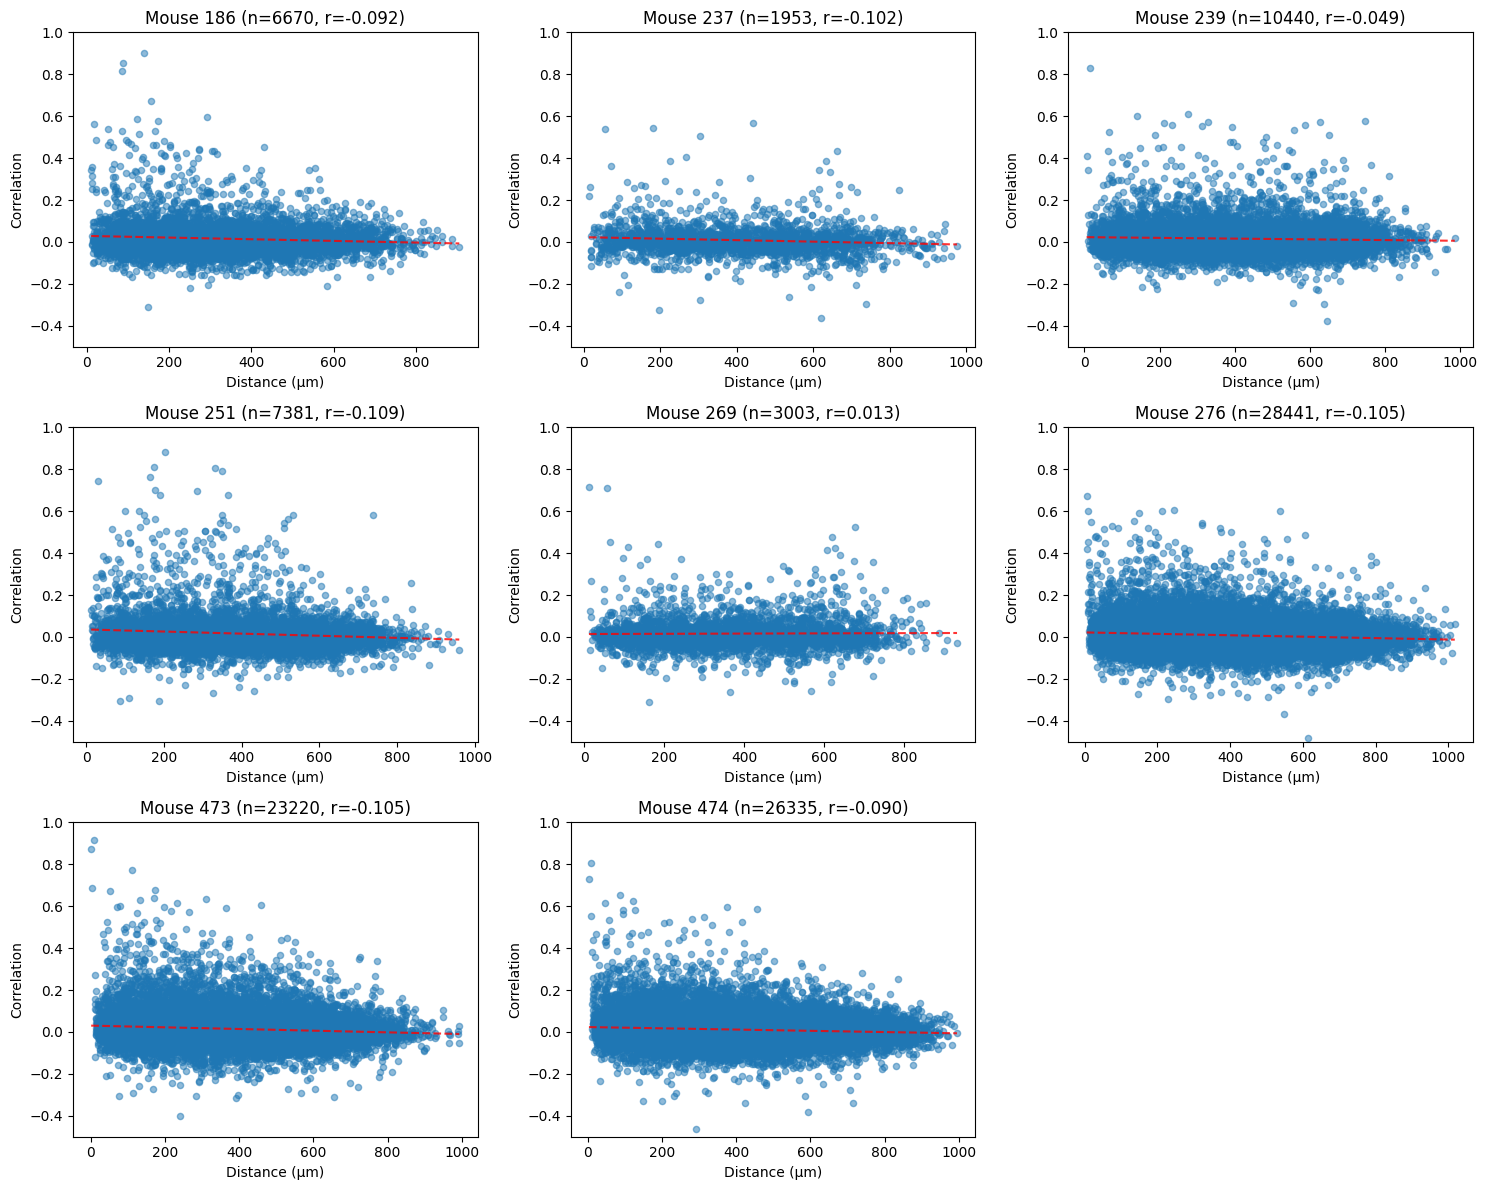

In [82]:
# saline_pre_pairwise = analyze_by_mouse(saline_pre_corr)
fig = plot_distance_correlation_by_mouse(psilo_post_corr)

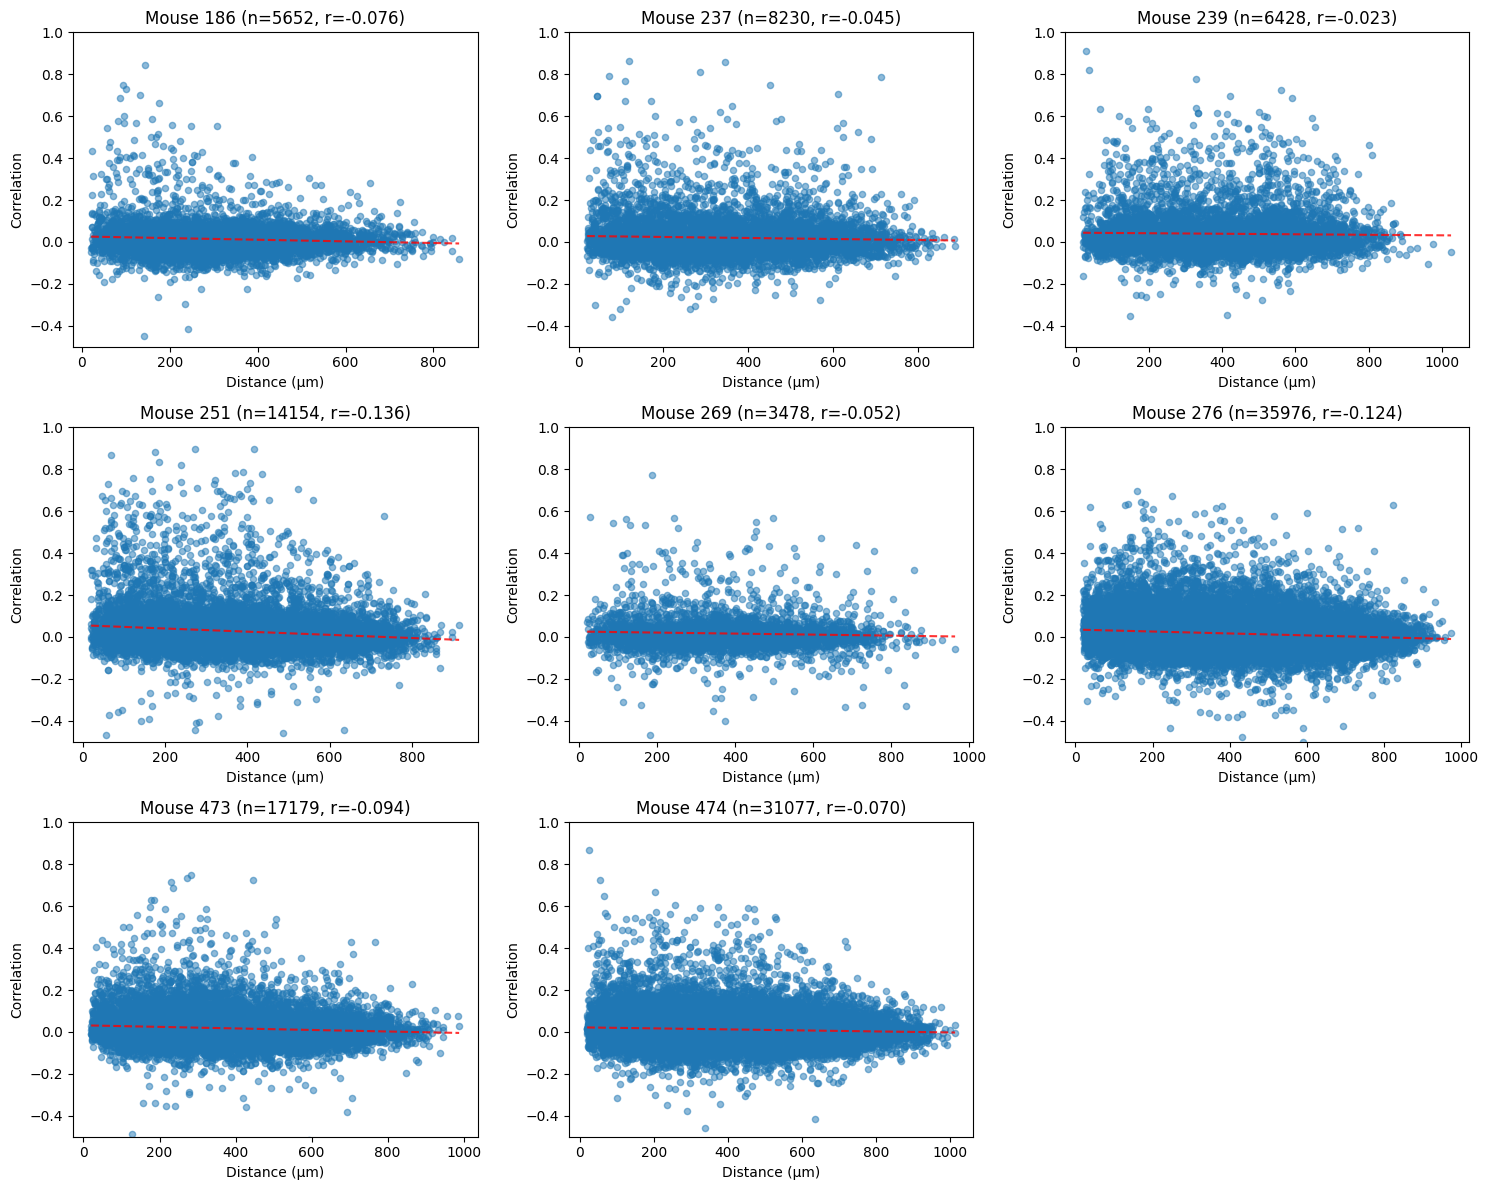

In [12]:
# Uses the output df from calculate_pairwise_metrics function
def clean_up_corrs(df,distance_threshold):
    filtered_df = df[df['distance'] >= distance_threshold]
    return filtered_df

filtered_saline_pre = clean_up_corrs(saline_pre_corr,20)
filtered_saline_post = clean_up_corrs(saline_post_corr,20)
filtered_psilo_pre = clean_up_corrs(psilo_pre_corr,20)
filtered_psilo_post = clean_up_corrs(psilo_post_corr,20)


fig2 = plot_distance_correlation_by_mouse(filtered_saline_pre)

In [13]:
def plot_distance_correlation_summary(pairwise_df, bin_size=50):
    """Create a summary plot with overall trend on left, individual mice on right"""
    
    unique_mice = pairwise_df['mouse_id'].unique()
    n_mice = len(unique_mice)
    
    # Create color map for individual mice
    colors = plt.cm.rainbow(np.linspace(0, 1, n_mice))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calculate overall statistics
    overall_r = np.corrcoef(pairwise_df['distance'], pairwise_df['correlation'])[0, 1]
    from scipy import stats
    slope, intercept, _, p_value, _ = stats.linregress(pairwise_df['distance'], pairwise_df['correlation'])
    
    # LEFT PLOT: All data points in gray with overall trend
    ax1.scatter(pairwise_df['distance'], pairwise_df['correlation'], 
               alpha=0.4, s=5, color='blue', label='All pairs')
    
    # Add overall trend line
    x_trend = np.linspace(pairwise_df['distance'].min(), pairwise_df['distance'].max(), 100)
    y_trend = slope * x_trend + intercept
    ax1.plot(x_trend, y_trend, 'r-', linewidth=3, 
             label=f'Trend: r={overall_r:.3f}, p={p_value:.3e}')
    
    # Add statistics text box
    textstr = f'n = {len(pairwise_df)} pairs\n'
    textstr += f'{n_mice} mice\n'
    textstr += f'r = {overall_r:.4f}\n'
    textstr += f'slope = {slope*1000:.3f}/mm'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax1.set_xlabel('Distance (μm)')
    ax1.set_ylabel('Correlation')
    ax1.set_title('Distance vs Correlation - All Data')
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.6)
    
    # RIGHT PLOT: Binned averages per mouse
    max_dist = pairwise_df['distance'].max()
    bins = np.arange(0, max_dist + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2
    
    for idx, mouse_id in enumerate(unique_mice):
        mouse_data = pairwise_df[pairwise_df['mouse_id'] == mouse_id].copy()
        
        # Bin the data
        mouse_data['distance_bin'] = pd.cut(mouse_data['distance'], bins=bins)
        binned = mouse_data.groupby('distance_bin')['correlation'].agg(['mean', 'sem']).reset_index()
        
        # Plot only bins with data
        valid_bins = ~binned['mean'].isna()
        ax2.errorbar(bin_centers[valid_bins], binned['mean'][valid_bins], 
                    yerr=binned['sem'][valid_bins], 
                    fmt='o-', color=colors[idx], alpha=0.7, 
                    label=f'Mouse {mouse_id}', capsize=3)
    
    ax2.set_xlabel('Distance (μm)')
    ax2.set_ylabel('Mean Correlation ± SEM')
    ax2.set_title('Binned Distance-Correlation Relationship')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_mouse_comparison_heatmap(pairwise_df):
    """Create a heatmap comparing distance-correlation relationships across mice"""
    
    # Create distance bins
    n_bins = 10
    pairwise_df['distance_bin'] = pd.cut(pairwise_df['distance'], bins=n_bins, labels=False)
    
    # Calculate mean correlation per distance bin per mouse
    heatmap_data = pairwise_df.pivot_table(
        values='correlation',
        index='mouse_id',
        columns='distance_bin',
        aggfunc='mean'
    )
    
    # Get distance bin labels
    bin_edges = pd.cut(pairwise_df['distance'], bins=n_bins, retbins=True)[1]
    bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(n_bins)]
    heatmap_data.columns = bin_labels
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='coolwarm', center=0, 
                cbar_kws={'label': 'Mean Correlation'},
                fmt='.2f', annot=True)
    plt.xlabel('Distance Bins (μm)')
    plt.ylabel('Mouse ID')
    plt.title('Mean Correlation by Distance Bin for Each Mouse')
    plt.tight_layout()
    
    return plt.gcf()

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\444849098.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = mouse_data.groupby('distance_bin')['correlation'].agg(['mean', 'sem']).reset_index()
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\444849098.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = mouse_data.groupby('distance_bin')['correlation'].agg(['mean', 'sem']).reset_index()
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\444849098.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fal

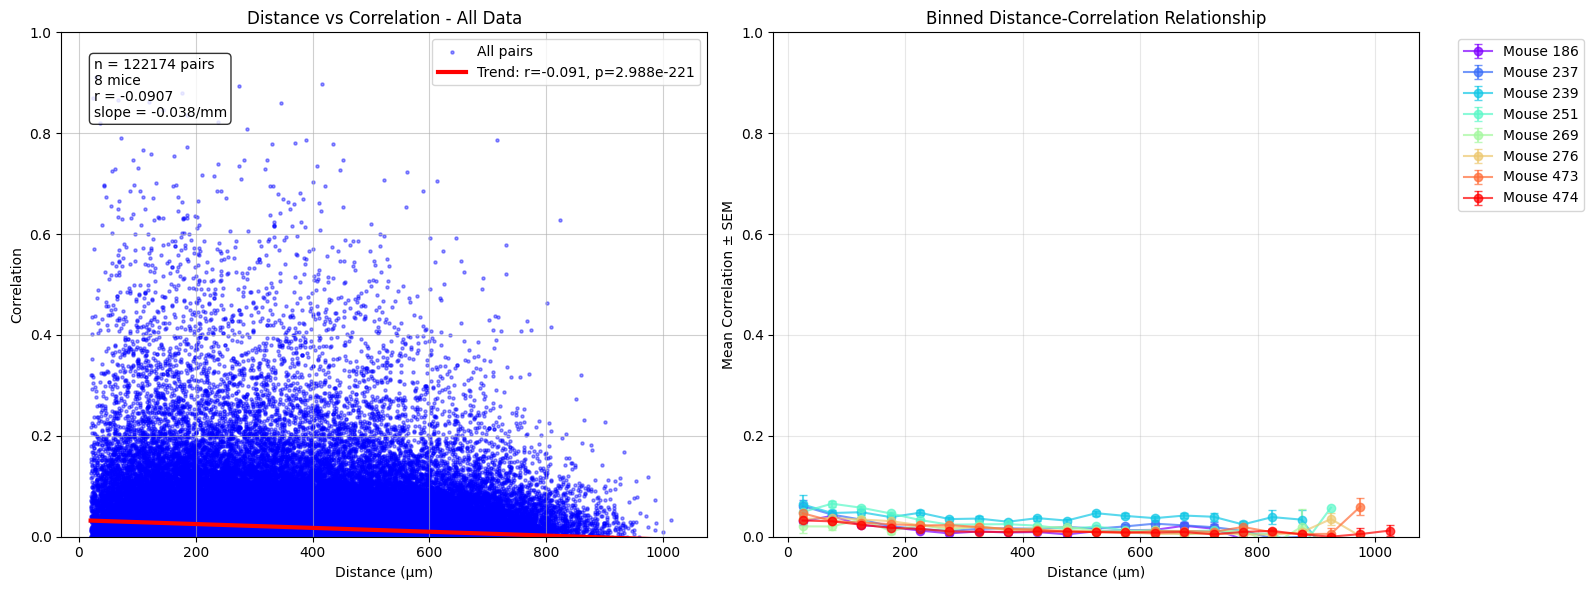

In [14]:
fig2 = plot_distance_correlation_summary(filtered_saline_pre)

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\444849098.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise_df['distance_bin'] = pd.cut(pairwise_df['distance'], bins=n_bins, labels=False)


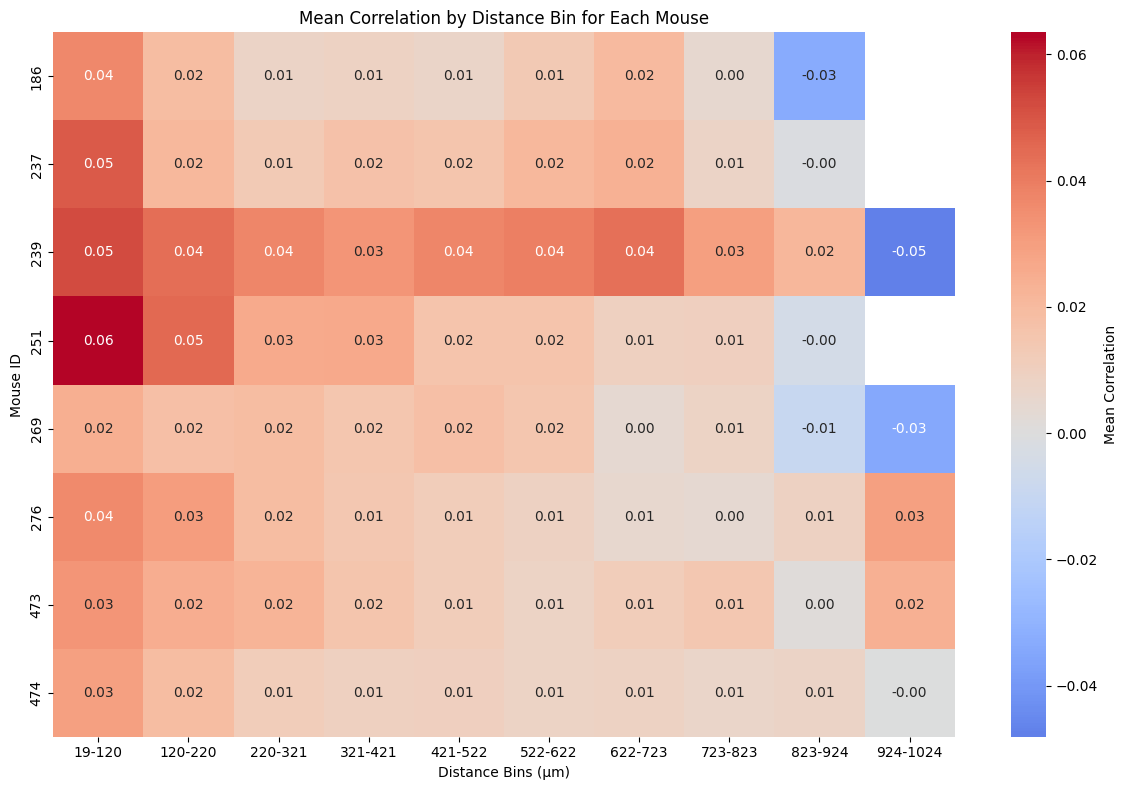

In [15]:
fig3 = plot_mouse_comparison_heatmap(filtered_saline_pre)

In [16]:
def analyze_distance_correlation(saline_pre, saline_post, psi_pre, psi_post):
    # Calculate distance-correlation relationship for each condition
    conditions = {
        'Saline Pre': saline_pre,
        'Saline Post': saline_post, 
        'Psi Pre': psi_pre,
        'Psi Post': psi_post
    }
    
    for name, df in conditions.items():
        r = np.corrcoef(df['distance'], df['correlation'])[0, 1]
        slope, intercept, _, p_value, _ = linregress(df['distance'], df['correlation'])
        print(f"{name}: r = {r:.4f}, slope = {slope*1000:.4f}/mm, p = {p_value:.3e}")

In [17]:
analyze_distance_correlation(saline_pre_corr,saline_post_corr,psilo_pre_corr,psilo_post_corr)

Saline Pre: r = -0.0960, slope = -0.0406/mm, p = 1.592e-248
Saline Post: r = -0.0841, slope = -0.0337/mm, p = 2.784e-179
Psi Pre: r = -0.0880, slope = -0.0360/mm, p = 4.121e-174
Psi Post: r = -0.0928, slope = -0.0334/mm, p = 5.333e-204


In [18]:
analyze_distance_correlation(filtered_saline_pre,filtered_saline_post,filtered_psilo_pre,filtered_psilo_post)

Saline Pre: r = -0.0907, slope = -0.0381/mm, p = 2.988e-221
Saline Post: r = -0.0780, slope = -0.0311/mm, p = 2.949e-154
Psi Pre: r = -0.0841, slope = -0.0343/mm, p = 1.042e-158
Psi Post: r = -0.0883, slope = -0.0316/mm, p = 1.094e-184


MEAN CORRELATIONS
Saline Pre:     0.0183
Saline Post:    0.0141
Psilocybin Pre: 0.0152
Psilocybin Post:0.0124

CHANGES IN MEAN CORRELATION
Saline (Post - Pre):     -0.0041
Psilocybin (Post - Pre): -0.0028

Difference (Psi - Saline): +0.0013

DISTANCE-CORRELATION RELATIONSHIPS
Correlation between distance and neural correlation (r):
Saline Pre:     -0.0907
Saline Post:    -0.0780
Psilocybin Pre: -0.0841
Psilocybin Post:-0.0883

Changes in distance-correlation relationship:
Saline (Post - Pre):     +0.0126
Psilocybin (Post - Pre): -0.0043

Difference (Psi - Saline): -0.0169

STATISTICAL SIGNIFICANCE

Mann-Whitney U tests (unpaired):
Saline Pre vs Post:     p = 0.0000
Psilocybin Pre vs Post: p = 0.0000

Baseline (Sal Pre vs Psi Pre): p = 0.0000

VISUALIZATION


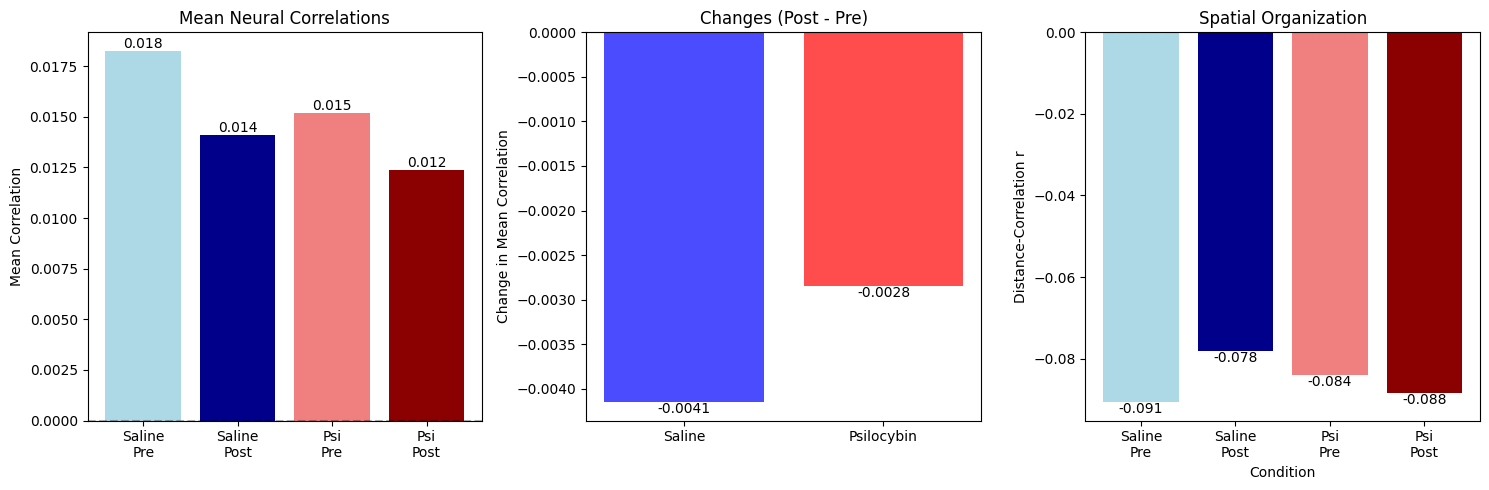

In [19]:
def population_correlation_analysis(saline_pre, saline_post, psi_pre, psi_post):
    """
    Simple population-level correlation analysis for unpaired data
    """
    
    # 1. MEAN CORRELATIONS
    print("="*60)
    print("MEAN CORRELATIONS")
    print("="*60)
    
    mean_sal_pre = saline_pre['correlation'].mean()
    mean_sal_post = saline_post['correlation'].mean()
    mean_psi_pre = psi_pre['correlation'].mean()
    mean_psi_post = psi_post['correlation'].mean()
    
    print(f"Saline Pre:     {mean_sal_pre:.4f}")
    print(f"Saline Post:    {mean_sal_post:.4f}")
    print(f"Psilocybin Pre: {mean_psi_pre:.4f}")
    print(f"Psilocybin Post:{mean_psi_post:.4f}")
    
    # 2. CHANGES IN MEAN CORRELATION
    print("\n" + "="*60)
    print("CHANGES IN MEAN CORRELATION")
    print("="*60)
    
    saline_change = mean_sal_post - mean_sal_pre
    psi_change = mean_psi_post - mean_psi_pre
    
    print(f"Saline (Post - Pre):     {saline_change:+.4f}")
    print(f"Psilocybin (Post - Pre): {psi_change:+.4f}")
    print(f"\nDifference (Psi - Saline): {psi_change - saline_change:+.4f}")
    
    # 3. DISTANCE-CORRELATION RELATIONSHIPS
    print("\n" + "="*60)
    print("DISTANCE-CORRELATION RELATIONSHIPS")
    print("="*60)
    
    # Calculate correlation between distance and neural correlation
    r_sal_pre = np.corrcoef(saline_pre['distance'], saline_pre['correlation'])[0,1]
    r_sal_post = np.corrcoef(saline_post['distance'], saline_post['correlation'])[0,1]
    r_psi_pre = np.corrcoef(psi_pre['distance'], psi_pre['correlation'])[0,1]
    r_psi_post = np.corrcoef(psi_post['distance'], psi_post['correlation'])[0,1]
    
    print("Correlation between distance and neural correlation (r):")
    print(f"Saline Pre:     {r_sal_pre:.4f}")
    print(f"Saline Post:    {r_sal_post:.4f}")
    print(f"Psilocybin Pre: {r_psi_pre:.4f}")
    print(f"Psilocybin Post:{r_psi_post:.4f}")
    
    # Changes in distance-correlation relationship
    print("\nChanges in distance-correlation relationship:")
    saline_r_change = r_sal_post - r_sal_pre
    psi_r_change = r_psi_post - r_psi_pre
    
    print(f"Saline (Post - Pre):     {saline_r_change:+.4f}")
    print(f"Psilocybin (Post - Pre): {psi_r_change:+.4f}")
    print(f"\nDifference (Psi - Saline): {psi_r_change - saline_r_change:+.4f}")
    
    # 4. STATISTICAL SIGNIFICANCE (using permutation test for unpaired data)
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE")
    print("="*60)
    
    from scipy import stats
    
    # Test if correlations are different between conditions
    print("\nMann-Whitney U tests (unpaired):")
    
    # Within-drug comparisons
    _, p_sal = stats.mannwhitneyu(saline_pre['correlation'], saline_post['correlation'])
    _, p_psi = stats.mannwhitneyu(psi_pre['correlation'], psi_post['correlation'])
    
    print(f"Saline Pre vs Post:     p = {p_sal:.4f}")
    print(f"Psilocybin Pre vs Post: p = {p_psi:.4f}")
    
    # Between-drug comparisons (baseline)
    _, p_baseline = stats.mannwhitneyu(saline_pre['correlation'], psi_pre['correlation'])
    print(f"\nBaseline (Sal Pre vs Psi Pre): p = {p_baseline:.4f}")
    
    # Simple visualization
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Mean correlations
    ax = axes[0]
    conditions = ['Saline\nPre', 'Saline\nPost', 'Psi\nPre', 'Psi\nPost']
    means = [mean_sal_pre, mean_sal_post, mean_psi_pre, mean_psi_post]
    colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred']
    
    bars = ax.bar(conditions, means, color=colors)
    ax.set_ylabel('Mean Correlation')
    ax.set_title('Mean Neural Correlations')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}', ha='center', va='bottom')
    
    # Plot 2: Changes
    ax = axes[1]
    changes = ['Saline', 'Psilocybin']
    change_values = [saline_change, psi_change]
    colors = ['blue', 'red']
    
    bars = ax.bar(changes, change_values, color=colors, alpha=0.7)
    ax.set_ylabel('Change in Mean Correlation')
    ax.set_title('Changes (Post - Pre)')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels
    for bar, val in zip(bars, change_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.4f}', ha='center', va='bottom' if val > 0 else 'top')
    
    # Plot 3: Distance-correlation relationships
    ax = axes[2]
    x = np.arange(len(conditions))
    r_values = [r_sal_pre, r_sal_post, r_psi_pre, r_psi_post]
    colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred']
    
    bars = ax.bar(x, r_values, color=colors)
    ax.set_xlabel('Condition')
    ax.set_ylabel('Distance-Correlation r')
    ax.set_title('Spatial Organization')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Add value labels
    for bar, r in zip(bars, r_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{r:.3f}', ha='center', va='bottom' if r > 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # Return summary statistics
    return {
        'mean_correlations': {
            'saline_pre': mean_sal_pre,
            'saline_post': mean_sal_post,
            'psi_pre': mean_psi_pre,
            'psi_post': mean_psi_post
        },
        'changes': {
            'saline': saline_change,
            'psilocybin': psi_change,
            'difference': psi_change - saline_change
        },
        'distance_effects': {
            'r_values': {
                'saline_pre': r_sal_pre,
                'saline_post': r_sal_post,
                'psi_pre': r_psi_pre,
                'psi_post': r_psi_post
            },
            'changes': {
                'saline': saline_r_change,
                'psilocybin': psi_r_change,
                'difference': psi_r_change - saline_r_change
            }
        }
    }

# Run the analysis
results = population_correlation_analysis(filtered_saline_pre,filtered_saline_post,filtered_psilo_pre,filtered_psilo_post)

STATISTICAL TESTS FOR CORRELATION CHANGES

1. Within-drug changes (Mann-Whitney U test):
----------------------------------------
Saline Pre vs Post:     p = 0.000000 ***
Psilocybin Pre vs Post: p = 0.000000 ***

2. Do drug effects differ? (Permutation test):
----------------------------------------
Psilocybin effect - Saline effect = +0.001306
Permutation test p-value = 0.003200 **

3. Bootstrap confidence intervals (95%):
----------------------------------------
Saline effect:     -0.004150 [-0.004765, -0.003523]
Psilocybin effect: -0.002843 [-0.003445, -0.002238]

4. Effect sizes (Cohen's d):
----------------------------------------
Saline effect size:     d = -0.0551 (small)
Psilocybin effect size: d = -0.0407 (small)

VISUALIZATION OF EFFECTS


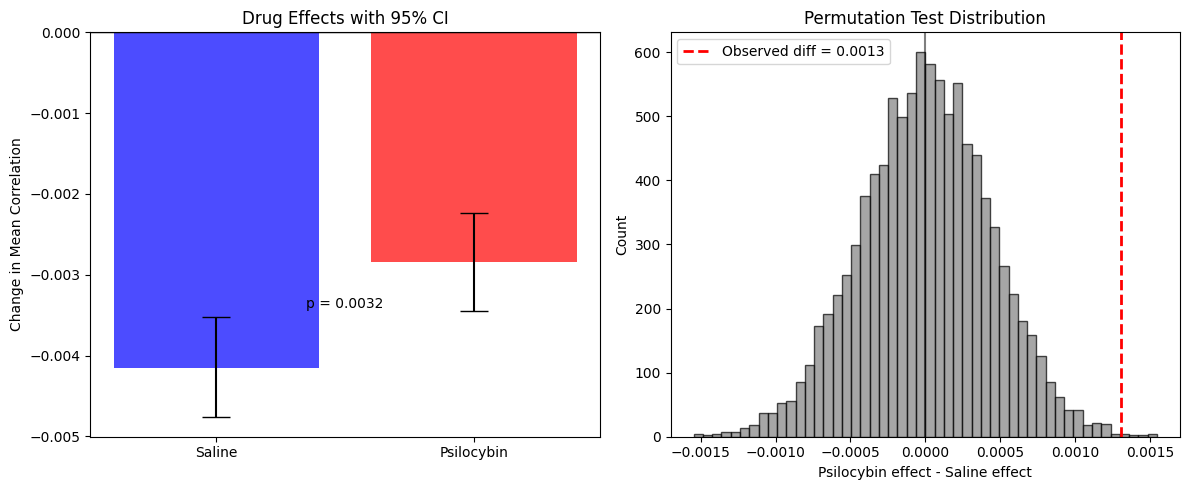


INTERPRETATION:
✓ The difference between psilocybin and saline effects is SIGNIFICANT
  Psilocybin changes correlations +0.0013 more than saline

✗ Saline has a larger effect size (0.055) than psilocybin (0.041)


In [20]:
def simple_statistics_for_effects(saline_pre, saline_post, psi_pre, psi_post):
    """
    Simple statistical tests for unpaired correlation data
    """
    from scipy import stats
    
    # Extract correlation values
    sal_pre = saline_pre['correlation'].values
    sal_post = saline_post['correlation'].values
    psi_pre = psi_pre['correlation'].values
    psi_post = psi_post['correlation'].values
    
    print("="*60)
    print("STATISTICAL TESTS FOR CORRELATION CHANGES")
    print("="*60)
    
    # 1. TEST WITHIN-DRUG CHANGES (Pre vs Post)
    print("\n1. Within-drug changes (Mann-Whitney U test):")
    print("-"*40)
    
    # Saline: Pre vs Post
    stat_sal, p_sal = stats.mannwhitneyu(sal_pre, sal_post, alternative='two-sided')
    print(f"Saline Pre vs Post:     p = {p_sal:.6f} {'***' if p_sal < 0.001 else '**' if p_sal < 0.01 else '*' if p_sal < 0.05 else 'ns'}")
    
    # Psilocybin: Pre vs Post  
    stat_psi, p_psi = stats.mannwhitneyu(psi_pre, psi_post, alternative='two-sided')
    print(f"Psilocybin Pre vs Post: p = {p_psi:.6f} {'***' if p_psi < 0.001 else '**' if p_psi < 0.01 else '*' if p_psi < 0.05 else 'ns'}")
    
    # 2. TEST IF DRUG EFFECTS DIFFER (Key question!)
    print("\n2. Do drug effects differ? (Permutation test):")
    print("-"*40)
    
    def permutation_test_for_interaction(sal_pre, sal_post, psi_pre, psi_post, n_perms=10000):
        """
        Test if psilocybin effect is different from saline effect
        """
        # Calculate observed effects
        saline_effect = np.mean(sal_post) - np.mean(sal_pre)
        psi_effect = np.mean(psi_post) - np.mean(psi_pre)
        observed_diff = psi_effect - saline_effect
        
        # Pool all data
        all_data = np.concatenate([sal_pre, sal_post, psi_pre, psi_post])
        n_sal_pre = len(sal_pre)
        n_sal_post = len(sal_post)
        n_psi_pre = len(psi_pre)
        n_psi_post = len(psi_post)
        
        # Permutation test
        perm_diffs = []
        for _ in range(n_perms):
            # Shuffle all data
            np.random.shuffle(all_data)
            
            # Assign to groups maintaining original sizes
            idx = 0
            perm_sal_pre = all_data[idx:idx+n_sal_pre]
            idx += n_sal_pre
            perm_sal_post = all_data[idx:idx+n_sal_post]
            idx += n_sal_post
            perm_psi_pre = all_data[idx:idx+n_psi_pre]
            idx += n_psi_pre
            perm_psi_post = all_data[idx:idx+n_psi_post]
            
            # Calculate permuted effects
            perm_sal_effect = np.mean(perm_sal_post) - np.mean(perm_sal_pre)
            perm_psi_effect = np.mean(perm_psi_post) - np.mean(perm_psi_pre)
            perm_diff = perm_psi_effect - perm_sal_effect
            
            perm_diffs.append(perm_diff)
        
        # Calculate p-value
        p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_perms
        
        return observed_diff, p_value, perm_diffs
    
    diff, p_interaction, perm_diffs = permutation_test_for_interaction(
        sal_pre, sal_post, psi_pre, psi_post
    )
    
    print(f"Psilocybin effect - Saline effect = {diff:+.6f}")
    print(f"Permutation test p-value = {p_interaction:.6f} {'***' if p_interaction < 0.001 else '**' if p_interaction < 0.01 else '*' if p_interaction < 0.05 else 'ns'}")
    
    # 3. CONFIDENCE INTERVALS (Bootstrap)
    print("\n3. Bootstrap confidence intervals (95%):")
    print("-"*40)
    
    def bootstrap_ci(data1, data2, n_boot=10000):
        """Calculate bootstrap CI for difference in means"""
        diffs = []
        for _ in range(n_boot):
            sample1 = np.random.choice(data1, size=len(data1), replace=True)
            sample2 = np.random.choice(data2, size=len(data2), replace=True)
            diffs.append(np.mean(sample2) - np.mean(sample1))
        return np.percentile(diffs, [2.5, 97.5])
    
    # CIs for each drug effect
    sal_ci = bootstrap_ci(sal_pre, sal_post)
    psi_ci = bootstrap_ci(psi_pre, psi_post)
    
    print(f"Saline effect:     {np.mean(sal_post)-np.mean(sal_pre):+.6f} [{sal_ci[0]:+.6f}, {sal_ci[1]:+.6f}]")
    print(f"Psilocybin effect: {np.mean(psi_post)-np.mean(psi_pre):+.6f} [{psi_ci[0]:+.6f}, {psi_ci[1]:+.6f}]")
    
    # 4. EFFECT SIZES (Cohen's d)
    print("\n4. Effect sizes (Cohen's d):")
    print("-"*40)
    
    def cohens_d(x, y):
        """Calculate Cohen's d for independent samples"""
        nx, ny = len(x), len(y)
        dof = nx + ny - 2
        return (np.mean(y) - np.mean(x)) / np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / dof)
    
    d_sal = cohens_d(sal_pre, sal_post)
    d_psi = cohens_d(psi_pre, psi_post)
    
    print(f"Saline effect size:     d = {d_sal:+.4f} ({'small' if abs(d_sal) < 0.5 else 'medium' if abs(d_sal) < 0.8 else 'large'})")
    print(f"Psilocybin effect size: d = {d_psi:+.4f} ({'small' if abs(d_psi) < 0.5 else 'medium' if abs(d_psi) < 0.8 else 'large'})")
    
    # 5. SIMPLE VISUALIZATION
    print("\n" + "="*60)
    print("VISUALIZATION OF EFFECTS")
    print("="*60)
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Effect sizes with CIs
    ax = axes[0]
    drugs = ['Saline', 'Psilocybin']
    effects = [np.mean(sal_post)-np.mean(sal_pre), np.mean(psi_post)-np.mean(psi_pre)]
    errors = [[effects[0]-sal_ci[0], effects[1]-psi_ci[0]], 
              [sal_ci[1]-effects[0], psi_ci[1]-effects[1]]]
    
    bars = ax.bar(drugs, effects, yerr=errors, capsize=10, 
                   color=['blue', 'red'], alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Change in Mean Correlation')
    ax.set_title('Drug Effects with 95% CI')
    
    # Add p-value annotation
    ax.text(0.5, max(effects)*1.2, f'p = {p_interaction:.4f}', 
            ha='center', transform=ax.transData)
    
    # Plot 2: Permutation test distribution
    ax = axes[1]
    ax.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black')
    ax.axvline(x=diff, color='red', linestyle='--', linewidth=2, 
               label=f'Observed diff = {diff:.4f}')
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax.set_xlabel('Psilocybin effect - Saline effect')
    ax.set_ylabel('Count')
    ax.set_title('Permutation Test Distribution')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # INTERPRETATION
    print("\n" + "="*60)
    print("INTERPRETATION:")
    print("="*60)
    
    if p_interaction < 0.05:
        print("✓ The difference between psilocybin and saline effects is SIGNIFICANT")
        print(f"  Psilocybin changes correlations {diff:+.4f} more than saline")
    else:
        print("✗ The difference between psilocybin and saline effects is NOT significant")
        print("  Both drugs have similar effects on neural correlations")
    
    if abs(d_psi) > abs(d_sal):
        print(f"\n✓ Psilocybin has a larger effect size ({abs(d_psi):.3f}) than saline ({abs(d_sal):.3f})")
    else:
        print(f"\n✗ Saline has a larger effect size ({abs(d_sal):.3f}) than psilocybin ({abs(d_psi):.3f})")

# Run the statistical analysis
simple_statistics_for_effects(filtered_saline_pre,filtered_saline_post,filtered_psilo_pre,filtered_psilo_post)

Text(0, 0.5, 'Pair Count')

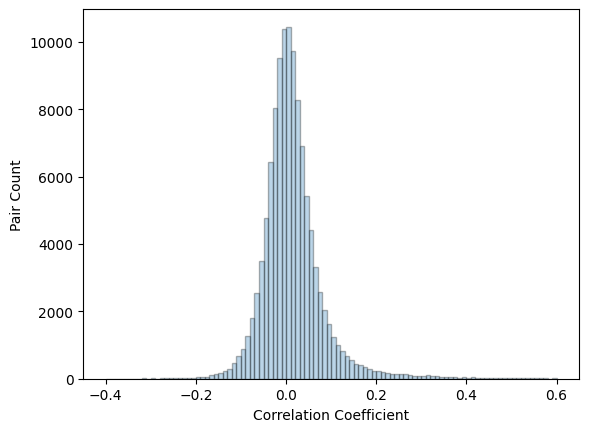

In [21]:
plt.hist(saline_post_corr['correlation'],bins=100,edgecolor='black',alpha=0.3,range=(-0.4,0.6))
plt.xlabel("Correlation Coefficient")
plt.ylabel("Pair Count")


In [22]:
def dict_to_pd_sig_noise(dict, condition):
    """
    Create wide format dataframe with one row per cell and columns for each trial
    """
    rows = []
    
    # Get important trial information
    first_mouse = next(iter(dict))
    first_cell = next(iter(dict[first_mouse]))
    traces = dict[first_mouse][first_cell]['traces']
    freqs = list(traces.keys())
    ints = list(traces[freqs[0]].keys())
    trials = list(traces[freqs[0]][ints[0]].keys())
    
    print(f"Frequencies: {freqs}")
    print(f"Intensities: {ints}")
    print(f"Trials per condition: {trials}")
    
    # Create column names for all trial combinations
    trial_columns = []
    for freq in freqs:
        for intensity in ints:
            for trial_num in trials:
                col_name = f"freq{freq}_int{intensity}_trial{trial_num}"
                trial_columns.append(col_name)
    
    for mouse_id, mouse_data in dict.items():
        base_mouse_id = mouse_id[-3:]
        
        for cell_id, cell_data in mouse_data.items():
            if cell_data['active'] == True:
                unique_cell_id = f"{mouse_id}_{condition}_{cell_id}"
                coords = cell_data['coords']
                
                # Use existing function to get standardized responses
                scaled_trials = prepare_cell_for_df(cell_data['deconvolved_traces'], freqs, ints, trials)
                
                # Create row with metadata
                row = {
                    'original_mouse_id': mouse_id,
                    'mouse_id': base_mouse_id,
                    'cell_id': cell_id,
                    'unique_cell_id': unique_cell_id,
                    'condition': condition,
                    'x_coord': coords[0] if isinstance(coords, (list, tuple)) else coords,
                    'y_coord': coords[1] if isinstance(coords, (list, tuple)) and len(coords) > 1 else None
                }
                
                # Add all trial responses as separate columns
                trial_index = 0
                for i, freq in enumerate(freqs):
                    for j, intensity in enumerate(ints):
                        for k, trial_num in enumerate(trials):
                            flat_index = i * len(ints) * len(trials) + j * len(trials) + k
                            col_name = f"freq{freq}_int{intensity}_trial{trial_num}"
                            row[col_name] = float(scaled_trials[flat_index])
                
                rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Ensure consistent column order
    metadata_cols = ['original_mouse_id', 'mouse_id', 'cell_id', 'unique_cell_id', 
                     'condition', 'x_coord', 'y_coord']
    df = df[metadata_cols + trial_columns]
    
    return df

In [23]:
saline_pre_sig_noise = dict_to_pd_sig_noise(saline_pre,'Pre')
saline_post_sig_noise = dict_to_pd_sig_noise(saline_post,'Post')
psilo_pre_sig_noise = dict_to_pd_sig_noise(psilo_pre,'Pre')
psilo_post_sig_noise = dict_to_pd_sig_noise(psilo_post,'Post')




Frequencies: [4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
Intensities: [35, 50, 65, 80]
Trials per condition: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies: [4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
Intensities: [35, 50, 65, 80]
Trials per condition: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies: [4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
Intensities: [35, 50, 65, 80]
Trials per condition: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies: [4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922]
Intensities: [35, 50, 65, 80]
Trials per condition: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [24]:
saline_pre_sig_noise

original_mouse_id mouse_id  cell_id         unique_cell_id condition  \
0         saline_1_186      186        4     saline_1_186_Pre_4       Pre   
1         saline_1_186      186        6     saline_1_186_Pre_6       Pre   
2         saline_1_186      186       12    saline_1_186_Pre_12       Pre   
3         saline_1_186      186       14    saline_1_186_Pre_14       Pre   
4         saline_1_186      186       15    saline_1_186_Pre_15       Pre   
...                ...      ...      ...                    ...       ...   
1303      saline_1_474      474     1148  saline_1_474_Pre_1148       Pre   
1304      saline_1_474      474     1199  saline_1_474_Pre_1199       Pre   
1305      saline_1_474      474     1217  saline_1_474_Pre_1217       Pre   
1306      saline_1_474      474     1497  saline_1_474_Pre_1497       Pre   
1307      saline_1_474      474     1666  saline_1_474_Pre_1666       Pre   

      x_coord  y_coord  freq4364_int35_trial1  freq4364_int35_trial2  \
0         187      207               0.233822              -0.107900   
1         263       75               1.083740               0.289845   
2         187      483               0.222345              -0.081668   
3         183      279              -0.410406               2.061772   
4         183      311              -0.374792              -0.154194   
...       ...      ...                    ...                    ...   
1303      121      289               0.474921               0.457063   
1304      199      405               2.563872              -0.962928   
1305      123      365              -0.252095              -0.252095   
1306      256      498               0.094906               0.984917   
1307      276       26              -1.230077               0.035342   

      freq4364_int35_trial3  ...  freq42922_int80_trial1  \
0                  0.062792  ...               -0.107900   
1                  1.409886  ...                0.514989   
2                  0.062712  ...               -0.073436   
3                 -0.356784  ...                0.002800   
4                 -0.285763  ...               -0.223042   
...                     ...  ...                     ...   
1303              -0.008598  ...                0.598027   
1304              -0.148311  ...               -0.144897   
1305              -0.583752  ...                1.753595   
1306              -0.062243  ...               -1.433470   
1307               0.035342  ...               -0.846054   

      freq42922_int80_trial2  freq42922_int80_trial3  freq42922_int80_trial4  \
0                   2.921653               -0.318776               -0.069433   
1                   0.304864                0.163433                0.476954   
2                  -0.081668               -0.171166                0.559637   
3                   0.327081               -0.188220                0.002800   
4                  -0.285763               -0.285763               -0.222425   
...                      ...                     ...                     ...   
1303               -0.935793                0.265374               -0.214827   
1304               -0.106949                0.010632               -0.148311   
1305                6.388119                2.534859               -1.433918   
1306               -0.132068               -1.985568                0.406867   
1307               -0.902985                0.343780               -1.508725   

      freq42922_int80_trial5  freq42922_int80_trial6  freq42922_int80_trial7  \
0                  -0.107900               -0.077954               -0.105402   
1                  -0.451774               -0.665605                0.531050   
2                  -0.081668                0.064804                0.165482   
3                   0.002800                0.002800                0.007955   
4                  -0.285763               -0.285763               -0.265884   
...                      ...                     ... 

In [25]:
def compute_signal_noise_correlations(df, pool_intensities=True):
    """
    Compute signal and noise correlations from wide format data
    """
    results = []
    
    # Identify trial columns
    trial_columns = [col for col in df.columns if col.startswith('freq')]
    
    for mouse_id in df['mouse_id'].unique():
        print(f"Processing mouse: {mouse_id}")
        
        mouse_df = df[df['mouse_id'] == mouse_id].reset_index(drop=True)
        
        if len(mouse_df) < 2:
            continue
        
        # Extract coordinates and trial data
        coords = mouse_df[['x_coord', 'y_coord']].values
        trial_data = mouse_df[trial_columns].values
        
        # Group columns by condition
        condition_groups = {}
        for col in trial_columns:
            parts = col.split('_')
            
            if pool_intensities:
                # Group by frequency only
                condition = f"{parts[0]}"  # freq4000, freq8000, etc.
            else:
                # Group by frequency and intensity
                condition = f"{parts[0]}_{parts[1]}"  # freq4000_int70, etc.
            
            if condition not in condition_groups:
                condition_groups[condition] = []
            condition_groups[condition].append(col)
        
        # Calculate condition means for signal correlation
        condition_means = np.array([
            mouse_df[cols].mean(axis=1).values 
            for condition, cols in sorted(condition_groups.items())
        ]).T
        
        # Calculate distances
        distances = squareform(pdist(coords, metric='euclidean'))
        
        n_cells = len(mouse_df)
        
        # Calculate correlation matrices
        signal_corr_matrix = np.corrcoef(condition_means)
        
        # For noise correlation, subtract condition means
        trial_data_centered = trial_data.copy()
        for condition, cols in sorted(condition_groups.items()):
            col_indices = [trial_columns.index(c) for c in cols]
            condition_mean = trial_data[:, col_indices].mean(axis=1, keepdims=True)
            trial_data_centered[:, col_indices] -= condition_mean
        
        noise_corr_matrix = np.corrcoef(trial_data_centered)
        
        # Extract pairwise correlations
        for i in range(n_cells):
            for j in range(i+1, n_cells):
                results.append({
                    'mouse_id': mouse_id,
                    'cell1': mouse_df.iloc[i]['unique_cell_id'],
                    'cell2': mouse_df.iloc[j]['unique_cell_id'],
                    'distance': distances[i, j],
                    'signal_correlation': signal_corr_matrix[i, j],
                    'noise_correlation': noise_corr_matrix[i, j],
                    'n_conditions': len(condition_groups),
                    'pooled_intensities': pool_intensities
                })
    
    return pd.DataFrame(results)

In [26]:
signoise_saline_pre = compute_signal_noise_correlations(saline_pre_sig_noise)
signoise_saline_post = compute_signal_noise_correlations(saline_post_sig_noise)
signoise_psilo_pre = compute_signal_noise_correlations(psilo_pre_sig_noise)
signoise_psilo_post = compute_signal_noise_correlations(psilo_post_sig_noise)

Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474
Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474
Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474
Processing mouse: 186
Processing mouse: 237
Processing mouse: 239
Processing mouse: 251
Processing mouse: 269
Processing mouse: 276
Processing mouse: 473
Processing mouse: 474


In [29]:
def plot_correlation_results(corr_df, title_prefix=""):
    """Quick visualization of signal/noise correlations"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Signal vs Noise correlation scatter
    ax = axes[0, 0]
    ax.scatter(corr_df['signal_correlation'], corr_df['noise_correlation'], 
               alpha=0.5, s=20)
    ax.set_xlabel('Signal Correlation')
    ax.set_ylabel('Noise Correlation')
    ax.set_title(f'Signal vs Noise Correlation {title_prefix}')
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # Add correlation coefficient
    r = corr_df['signal_correlation'].corr(corr_df['noise_correlation'])
    ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Distance vs Noise correlation
    ax = axes[0, 1]
    ax.scatter(corr_df['distance'], corr_df['noise_correlation'], 
               alpha=0.5, s=20)
    ax.set_xlabel('Distance (pixels)')
    ax.set_ylabel('Noise Correlation')
    ax.set_title('Distance-dependent noise correlations')
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # 3. Histograms
    ax = axes[1, 0]
    ax.hist(corr_df['signal_correlation'].dropna(), bins=50, alpha=0.7, 
            label='Signal', color='blue', density=True)
    ax.hist(corr_df['noise_correlation'].dropna(), bins=50, alpha=0.7, 
            label='Noise', color='red', density=True)
    ax.set_xlabel('Correlation coefficient')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of correlations')
    ax.legend()
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # 4. Distance vs Signal correlation (NEW - replaces boxplot)
#  =
#                alpha=0.3, s=20, color='orange')
#     ax.set_xlabel('Distance (pixels)')
#     ax.set_ylabel('Signal Correlation')
#     ax.set_title('Distance-dependent signal correlations')
#     ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
#     plt.tight_layout()
#     return fig

In [30]:
filtered_signoise_saline_pre = clean_up_corrs(signoise_saline_pre,20)

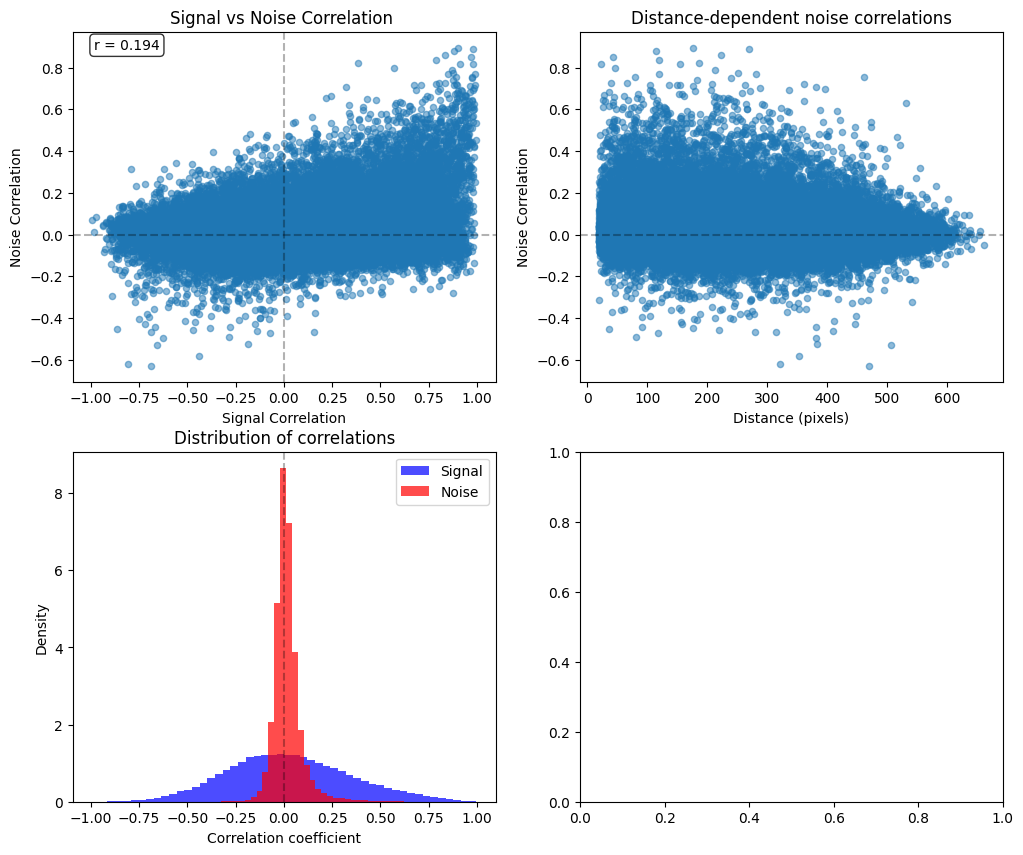

In [31]:
fig4 = plot_correlation_results(filtered_signoise_saline_pre)

In [33]:
def plot_distance_binned_correlations(corr_df, n_bins=10):
    """Show how correlations change with distance - in pixels"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Create distance bins
    corr_df['distance_bin'], bin_edges = pd.qcut(corr_df['distance'], 
                                                  n_bins, retbins=True, duplicates='drop')
    
    # Calculate stats
    binned_stats = corr_df.groupby('distance_bin').agg({
        'noise_correlation': ['mean', 'sem'],
        'signal_correlation': ['mean', 'sem'],
        'distance': 'mean'
    })
    
    # Use actual distances for x-axis
    x_positions = binned_stats['distance']['mean']
    
    # Plot with actual distance values
    ax1.errorbar(x_positions, binned_stats['noise_correlation']['mean'], 
                yerr=binned_stats['noise_correlation']['sem'],
                marker='o', capsize=5, markersize=8)
    ax1.set_xlabel('Distance (pixels)')
    ax1.set_ylabel('Noise correlation')
    ax1.set_title('Mean noise correlations vs distance')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    ax2.errorbar(x_positions, binned_stats['signal_correlation']['mean'], 
                yerr=binned_stats['signal_correlation']['sem'],
                marker='o', capsize=5, markersize=8, color='orange')
    ax2.set_xlabel('Distance (pixels)')
    ax2.set_ylabel('Signal correlation')
    ax2.set_title('Mean signal correlations vs distance')
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, binned_stats

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\1437887517.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['distance_bin'], bin_edges = pd.qcut(corr_df['distance'],
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\1437887517.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = corr_df.groupby('distance_bin').agg({


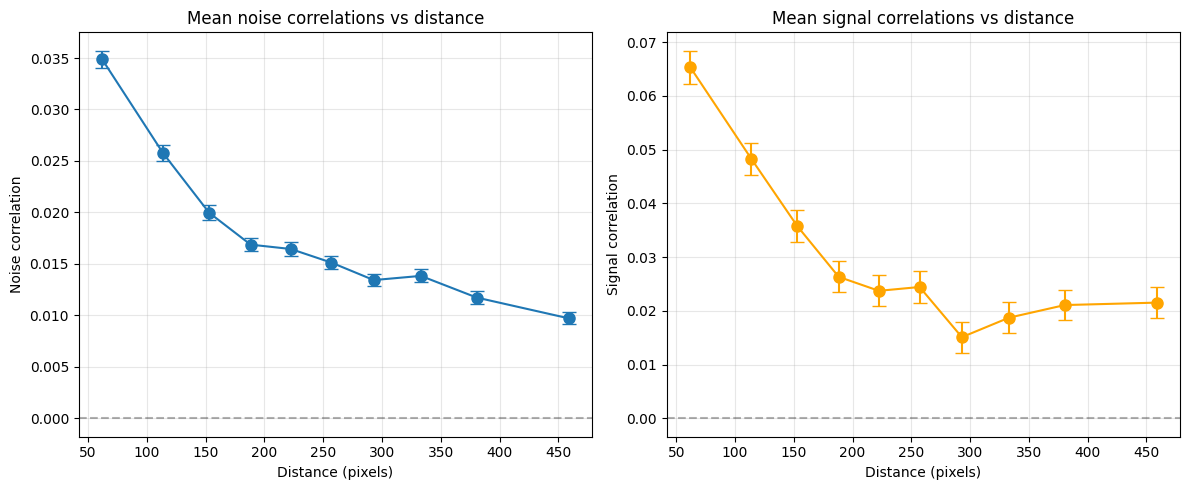

In [34]:
fig = plot_distance_binned_correlations(filtered_signoise_saline_pre)

SPATIAL ORGANIZATION ANALYSIS
Saline Pre      r = -0.0907
Saline Post     r = -0.0780
Psi Pre         r = -0.0841
Psi Post        r = -0.0883

Changes (Post - Pre):
Saline:     Δr = +0.0126
Psilocybin: Δr = -0.0043
Difference: -0.0169

STATISTICAL TESTING

Per-mouse changes:
Saline mice (n=8): 0.0084 ± 0.0241
Psi mice (n=8): 0.0123 ± 0.0289

Permutation test: p = 0.7968


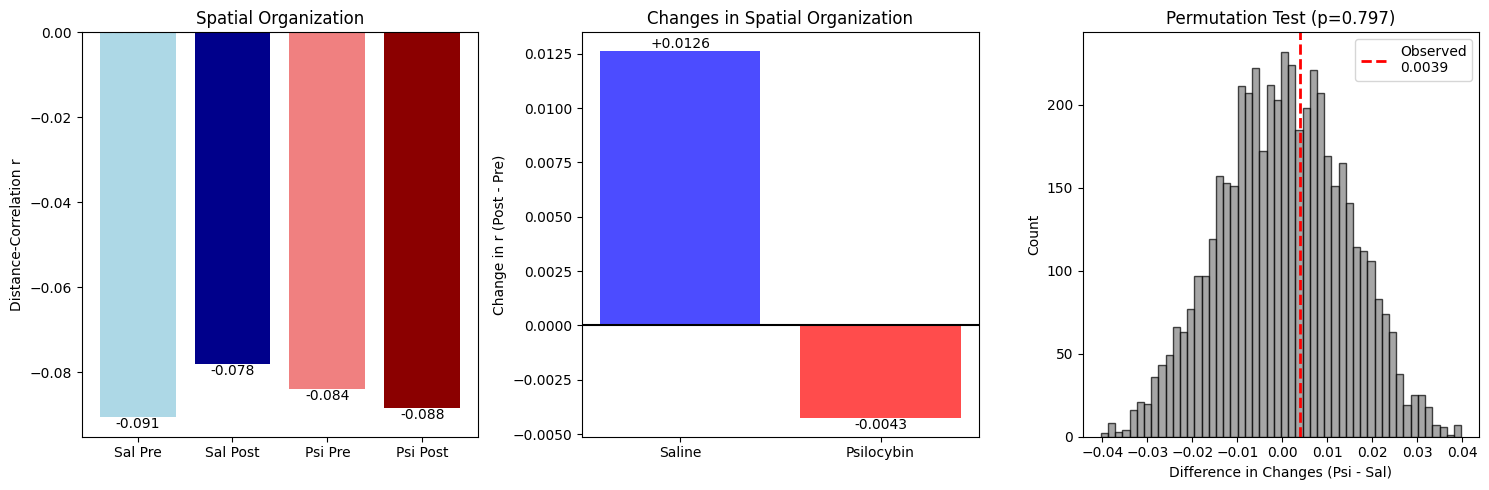

In [35]:
def spatial_organization_analysis(saline_pre, saline_post, psi_pre, psi_post):
    """
    Succinct analysis of spatial organization changes
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    print("="*60)
    print("SPATIAL ORGANIZATION ANALYSIS")
    print("="*60)
    
    # 1. Calculate distance-correlation r for each condition
    conditions = {
        'Saline Pre': saline_pre,
        'Saline Post': saline_post,
        'Psi Pre': psi_pre,
        'Psi Post': psi_post
    }
    
    r_values = {}
    for name, df in conditions.items():
        r = np.corrcoef(df['distance'], df['correlation'])[0,1]
        r_values[name] = r
        print(f"{name:15} r = {r:.4f}")
    
    # 2. Calculate changes
    print(f"\nChanges (Post - Pre):")
    saline_change = r_values['Saline Post'] - r_values['Saline Pre']
    psi_change = r_values['Psi Post'] - r_values['Psi Pre']
    
    print(f"Saline:     Δr = {saline_change:+.4f}")
    print(f"Psilocybin: Δr = {psi_change:+.4f}")
    print(f"Difference: {psi_change - saline_change:+.4f}")
    
    # 3. Statistical test: Permutation test respecting mouse structure
    def permutation_test(sal_pre, sal_post, psi_pre, psi_post, n_perms=5000):
        """Test if change in psi differs from change in saline"""
        
        # Calculate per-mouse changes
        def get_mouse_changes(pre_df, post_df):
            changes = []
            for mouse in pre_df['mouse_id'].unique():
                if mouse in post_df['mouse_id'].unique():
                    m_pre = pre_df[pre_df['mouse_id'] == mouse]
                    m_post = post_df[post_df['mouse_id'] == mouse]
                    if len(m_pre) > 20 and len(m_post) > 20:  # Enough pairs
                        r_pre = np.corrcoef(m_pre['distance'], m_pre['correlation'])[0,1]
                        r_post = np.corrcoef(m_post['distance'], m_post['correlation'])[0,1]
                        changes.append(r_post - r_pre)
            return np.array(changes)
        
        # Get observed changes per mouse
        sal_changes = get_mouse_changes(sal_pre, sal_post)
        psi_changes = get_mouse_changes(psi_pre, psi_post)
        
        # Observed difference in means
        obs_diff = np.mean(psi_changes) - np.mean(sal_changes)
        
        # Permutation test
        all_changes = np.concatenate([sal_changes, psi_changes])
        n_sal = len(sal_changes)
        
        perm_diffs = []
        for _ in range(n_perms):
            np.random.shuffle(all_changes)
            perm_sal = all_changes[:n_sal]
            perm_psi = all_changes[n_sal:]
            perm_diffs.append(np.mean(perm_psi) - np.mean(perm_sal))
        
        p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
        
        return obs_diff, p_value, sal_changes, psi_changes, perm_diffs
    
    print("\n" + "="*60)
    print("STATISTICAL TESTING")
    print("="*60)
    
    obs_diff, p_value, sal_changes, psi_changes, perm_diffs = permutation_test(
        saline_pre, saline_post, psi_pre, psi_post
    )
    
    print(f"\nPer-mouse changes:")
    print(f"Saline mice (n={len(sal_changes)}): {sal_changes.mean():.4f} ± {sal_changes.std():.4f}")
    print(f"Psi mice (n={len(psi_changes)}): {psi_changes.mean():.4f} ± {psi_changes.std():.4f}")
    print(f"\nPermutation test: p = {p_value:.4f}")
    
    # 4. Simple visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Panel 1: Bar plot of r values
    ax = axes[0]
    x = np.arange(4)
    colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred']
    bars = ax.bar(x, list(r_values.values()), color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(['Sal Pre', 'Sal Post', 'Psi Pre', 'Psi Post'])
    ax.set_ylabel('Distance-Correlation r')
    ax.set_title('Spatial Organization')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    
    # Add values on bars
    for bar, r in zip(bars, r_values.values()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{r:.3f}', ha='center', va='bottom' if r > 0 else 'top')
    
    # Panel 2: Changes by condition
    ax = axes[1]
    conditions = ['Saline', 'Psilocybin']
    changes = [saline_change, psi_change]
    colors = ['blue', 'red']
    bars = ax.bar(conditions, changes, color=colors, alpha=0.7)
    ax.set_ylabel('Change in r (Post - Pre)')
    ax.set_title('Changes in Spatial Organization')
    ax.axhline(0, color='black', linestyle='-')
    
    for bar, val in zip(bars, changes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{val:+.4f}', ha='center', va='bottom' if val > 0 else 'top')
    
    # Panel 3: Permutation test
    ax = axes[2]
    ax.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black')
    ax.axvline(obs_diff, color='red', linestyle='--', linewidth=2, 
               label=f'Observed\n{obs_diff:.4f}')
    ax.set_xlabel('Difference in Changes (Psi - Sal)')
    ax.set_ylabel('Count')
    ax.set_title(f'Permutation Test (p={p_value:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'r_values': r_values,
        'changes': {'saline': saline_change, 'psilocybin': psi_change},
        'p_value': p_value
    }

# Run the analysis
results = spatial_organization_analysis(
    filtered_saline_pre, filtered_saline_post,
    filtered_psilo_pre, filtered_psilo_post
)

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\1156498410.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('dist_bin')['correlation'].agg(['mean', 'std', 'count'])
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\1156498410.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('dist_bin')['correlation'].agg(['mean', 'std', 'count'])
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\1156498410.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beha

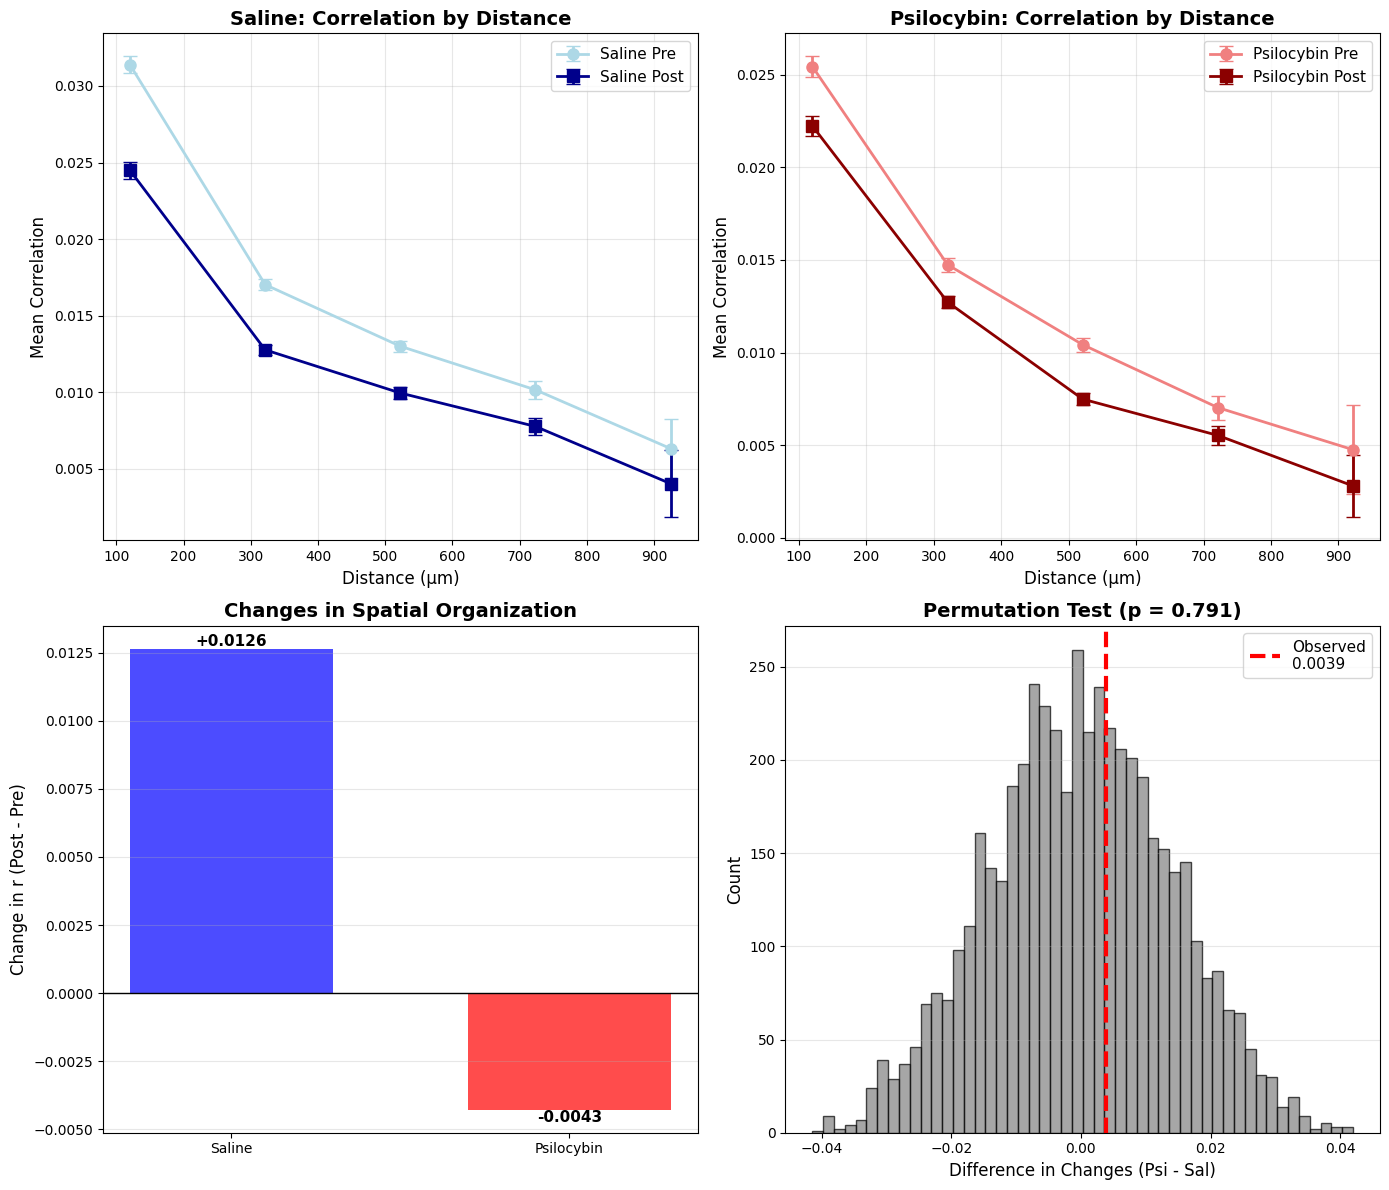

SPATIAL ORGANIZATION SUMMARY
Distance-correlation r values:
  Saline Pre:     -0.0907
  Saline Post:    -0.0780
  Psi Pre:        -0.0841
  Psi Post:       -0.0883

Changes (Post - Pre):
  Saline:         +0.0126
  Psilocybin:     -0.0043

Difference:       -0.0169
Permutation test: p = 0.7912


In [36]:
def combined_spatial_analysis(saline_pre, saline_post, psi_pre, psi_post, n_bins=5):
    """
    Combined 4-panel spatial organization analysis
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Helper function for distance binning
    def analyze_by_distance_bins(df, n_bins):
        bins = np.linspace(df['distance'].min(), df['distance'].max(), n_bins+1)
        df['dist_bin'] = pd.cut(df['distance'], bins=bins, labels=range(n_bins))
        bin_stats = df.groupby('dist_bin')['correlation'].agg(['mean', 'std', 'count'])
        bin_centers = [(bins[i] + bins[i+1])/2 for i in range(n_bins)]
        return bin_stats, bin_centers
    
    # PANEL 1: Saline correlation by distance
    ax = axes[0, 0]
    
    # Saline Pre
    bin_stats_pre, bin_centers = analyze_by_distance_bins(saline_pre.copy(), n_bins)
    ax.errorbar(bin_centers, bin_stats_pre['mean'], 
                yerr=bin_stats_pre['std']/np.sqrt(bin_stats_pre['count']),
                marker='o', capsize=5, color='lightblue', linewidth=2,
                label='Saline Pre', markersize=8)
    
    # Saline Post  
    bin_stats_post, _ = analyze_by_distance_bins(saline_post.copy(), n_bins)
    ax.errorbar(bin_centers, bin_stats_post['mean'],
                yerr=bin_stats_post['std']/np.sqrt(bin_stats_post['count']),
                marker='s', capsize=5, color='darkblue', linewidth=2,
                label='Saline Post', markersize=8)
    
    ax.set_xlabel('Distance (μm)', fontsize=12)
    ax.set_ylabel('Mean Correlation', fontsize=12)
    ax.set_title('Saline: Correlation by Distance', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # PANEL 2: Psilocybin correlation by distance
    ax = axes[0, 1]
    
    # Psi Pre
    bin_stats_pre, bin_centers = analyze_by_distance_bins(psi_pre.copy(), n_bins)
    ax.errorbar(bin_centers, bin_stats_pre['mean'],
                yerr=bin_stats_pre['std']/np.sqrt(bin_stats_pre['count']),
                marker='o', capsize=5, color='lightcoral', linewidth=2,
                label='Psilocybin Pre', markersize=8)
    
    # Psi Post
    bin_stats_post, _ = analyze_by_distance_bins(psi_post.copy(), n_bins)
    ax.errorbar(bin_centers, bin_stats_post['mean'],
                yerr=bin_stats_post['std']/np.sqrt(bin_stats_post['count']),
                marker='s', capsize=5, color='darkred', linewidth=2,
                label='Psilocybin Post', markersize=8)
    
    ax.set_xlabel('Distance (μm)', fontsize=12)
    ax.set_ylabel('Mean Correlation', fontsize=12)
    ax.set_title('Psilocybin: Correlation by Distance', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Calculate r values for panels 3 and 4
    r_sal_pre = np.corrcoef(saline_pre['distance'], saline_pre['correlation'])[0,1]
    r_sal_post = np.corrcoef(saline_post['distance'], saline_post['correlation'])[0,1]
    r_psi_pre = np.corrcoef(psi_pre['distance'], psi_pre['correlation'])[0,1]
    r_psi_post = np.corrcoef(psi_post['distance'], psi_post['correlation'])[0,1]
    
    saline_change = r_sal_post - r_sal_pre
    psi_change = r_psi_post - r_psi_pre
    
    # PANEL 3: Changes in spatial organization
    ax = axes[1, 0]
    conditions = ['Saline', 'Psilocybin']
    changes = [saline_change, psi_change]
    colors = ['blue', 'red']
    bars = ax.bar(conditions, changes, color=colors, alpha=0.7, width=0.6)
    
    ax.set_ylabel('Change in r (Post - Pre)', fontsize=12)
    ax.set_title('Changes in Spatial Organization', fontsize=14, fontweight='bold')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, changes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{val:+.4f}', ha='center', va='bottom' if val > 0 else 'top',
                fontsize=11, fontweight='bold')
    
    # PANEL 4: Permutation test
    ax = axes[1, 1]
    
    # Permutation test function
    def permutation_test(sal_pre, sal_post, psi_pre, psi_post, n_perms=5000):
        def get_mouse_changes(pre_df, post_df):
            changes = []
            for mouse in pre_df['mouse_id'].unique():
                if mouse in post_df['mouse_id'].unique():
                    m_pre = pre_df[pre_df['mouse_id'] == mouse]
                    m_post = post_df[post_df['mouse_id'] == mouse]
                    if len(m_pre) > 20 and len(m_post) > 20:
                        r_pre = np.corrcoef(m_pre['distance'], m_pre['correlation'])[0,1]
                        r_post = np.corrcoef(m_post['distance'], m_post['correlation'])[0,1]
                        changes.append(r_post - r_pre)
            return np.array(changes)
        
        sal_changes = get_mouse_changes(sal_pre, sal_post)
        psi_changes = get_mouse_changes(psi_pre, psi_post)
        obs_diff = np.mean(psi_changes) - np.mean(sal_changes)
        
        all_changes = np.concatenate([sal_changes, psi_changes])
        n_sal = len(sal_changes)
        
        perm_diffs = []
        for _ in range(n_perms):
            np.random.shuffle(all_changes)
            perm_sal = all_changes[:n_sal]
            perm_psi = all_changes[n_sal:]
            perm_diffs.append(np.mean(perm_psi) - np.mean(perm_sal))
        
        p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
        return obs_diff, p_value, perm_diffs
    
    obs_diff, p_value, perm_diffs = permutation_test(
        saline_pre, saline_post, psi_pre, psi_post
    )
    
    ax.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black')
    ax.axvline(obs_diff, color='red', linestyle='--', linewidth=3,
               label=f'Observed\n{obs_diff:.4f}')
    ax.set_xlabel('Difference in Changes (Psi - Sal)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Permutation Test (p = {p_value:.3f})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("="*60)
    print("SPATIAL ORGANIZATION SUMMARY")
    print("="*60)
    print(f"Distance-correlation r values:")
    print(f"  Saline Pre:     {r_sal_pre:.4f}")
    print(f"  Saline Post:    {r_sal_post:.4f}")
    print(f"  Psi Pre:        {r_psi_pre:.4f}")
    print(f"  Psi Post:       {r_psi_post:.4f}")
    print(f"\nChanges (Post - Pre):")
    print(f"  Saline:         {saline_change:+.4f}")
    print(f"  Psilocybin:     {psi_change:+.4f}")
    print(f"\nDifference:       {psi_change - saline_change:+.4f}")
    print(f"Permutation test: p = {p_value:.4f}")
    
    return {
        'r_values': {
            'saline_pre': r_sal_pre, 'saline_post': r_sal_post,
            'psi_pre': r_psi_pre, 'psi_post': r_psi_post
        },
        'changes': {'saline': saline_change, 'psilocybin': psi_change},
        'p_value': p_value
    }

# Run the combined analysis
results = combined_spatial_analysis(
    filtered_saline_pre, filtered_saline_post,
    filtered_psilo_pre, filtered_psilo_post
)

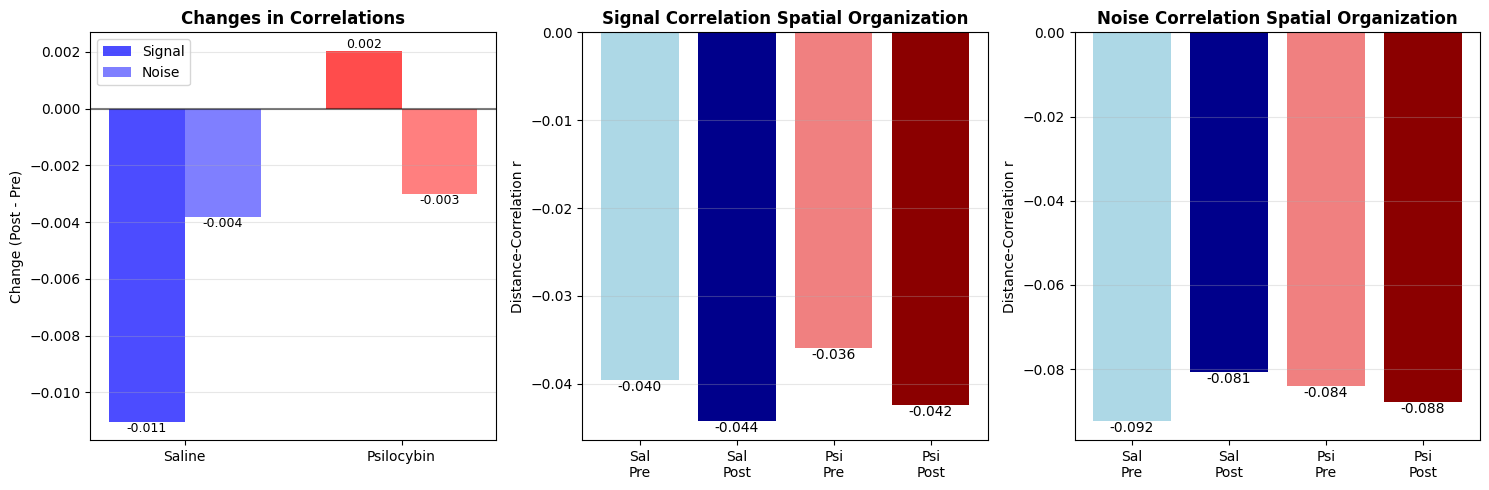

SUMMARY OF CHANGES (Post - Pre)

Mean Correlations:
Signal - Saline: -0.0110, Psilocybin: +0.0020
Noise  - Saline: -0.0038, Psilocybin: -0.0030

Spatial Organization (r):
Signal - Saline: -0.0046, Psilocybin: -0.0065
Noise  - Saline: +0.0117, Psilocybin: -0.0040


In [37]:
def analyze_signal_noise_changes(saline_pre, saline_post, psi_pre, psi_post):
    """
    Focused analysis on changes in signal/noise correlations and their spatial organization
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Calculate all the metrics
    conditions = {
        'Saline Pre': saline_pre,
        'Saline Post': saline_post,
        'Psi Pre': psi_pre,
        'Psi Post': psi_post
    }
    
    results = {'signal': {}, 'noise': {}}
    
    for corr_type in ['signal', 'noise']:
        for name, df in conditions.items():
            mean_corr = df[f'{corr_type}_correlation'].mean()
            r = np.corrcoef(df['distance'], df[f'{corr_type}_correlation'])[0,1]
            results[corr_type][name] = {'mean': mean_corr, 'r': r}
    
    # PANEL 1: Changes in both signal and noise
    ax = axes[0]
    
    signal_sal_change = results['signal']['Saline Post']['mean'] - results['signal']['Saline Pre']['mean']
    signal_psi_change = results['signal']['Psi Post']['mean'] - results['signal']['Psi Pre']['mean']
    noise_sal_change = results['noise']['Saline Post']['mean'] - results['noise']['Saline Pre']['mean']
    noise_psi_change = results['noise']['Psi Post']['mean'] - results['noise']['Psi Pre']['mean']
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = ax.bar(x - width/2, [signal_sal_change, signal_psi_change], width, 
                    label='Signal', color=['blue', 'red'], alpha=0.7)
    bars2 = ax.bar(x + width/2, [noise_sal_change, noise_psi_change], width,
                    label='Noise', color=['blue', 'red'], alpha=0.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.3f}', ha='center', 
                    va='bottom' if height > 0 else 'top', fontsize=9)
    
    ax.set_xticks(x)
    ax.set_xticklabels(['Saline', 'Psilocybin'])
    ax.set_ylabel('Change (Post - Pre)')
    ax.set_title('Changes in Correlations', fontweight='bold')
    ax.legend()
    ax.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax.grid(True, alpha=0.3, axis='y')
    
    # PANEL 2: Spatial organization of signal correlations
    ax = axes[1]
    signal_r_values = [results['signal'][n]['r'] for n in conditions.keys()]
    colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred']
    
    bars = ax.bar(range(4), signal_r_values, color=colors)
    ax.set_xticks(range(4))
    ax.set_xticklabels(['Sal\nPre', 'Sal\nPost', 'Psi\nPre', 'Psi\nPost'])
    ax.set_ylabel('Distance-Correlation r')
    ax.set_title('Signal Correlation Spatial Organization', fontweight='bold')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, signal_r_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top')
    
    # PANEL 3: Spatial organization of noise correlations
    ax = axes[2]
    noise_r_values = [results['noise'][n]['r'] for n in conditions.keys()]
    
    bars = ax.bar(range(4), noise_r_values, color=colors)
    ax.set_xticks(range(4))
    ax.set_xticklabels(['Sal\nPre', 'Sal\nPost', 'Psi\nPre', 'Psi\nPost'])
    ax.set_ylabel('Distance-Correlation r')
    ax.set_title('Noise Correlation Spatial Organization', fontweight='bold')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, noise_r_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("="*60)
    print("SUMMARY OF CHANGES (Post - Pre)")
    print("="*60)
    print("\nMean Correlations:")
    print(f"Signal - Saline: {signal_sal_change:+.4f}, Psilocybin: {signal_psi_change:+.4f}")
    print(f"Noise  - Saline: {noise_sal_change:+.4f}, Psilocybin: {noise_psi_change:+.4f}")
    
    print("\nSpatial Organization (r):")
    signal_r_sal_change = results['signal']['Saline Post']['r'] - results['signal']['Saline Pre']['r']
    signal_r_psi_change = results['signal']['Psi Post']['r'] - results['signal']['Psi Pre']['r']
    noise_r_sal_change = results['noise']['Saline Post']['r'] - results['noise']['Saline Pre']['r']
    noise_r_psi_change = results['noise']['Psi Post']['r'] - results['noise']['Psi Pre']['r']
    
    print(f"Signal - Saline: {signal_r_sal_change:+.4f}, Psilocybin: {signal_r_psi_change:+.4f}")
    print(f"Noise  - Saline: {noise_r_sal_change:+.4f}, Psilocybin: {noise_r_psi_change:+.4f}")
    
    return results

# Run the analysis
results = analyze_signal_noise_changes(
    signoise_saline_pre, signoise_saline_post, signoise_psilo_pre, signoise_psilo_post
)

In [38]:
def test_signal_noise_significance(saline_pre, saline_post, psi_pre, psi_post):
    """
    Quick statistical tests for signal and noise correlation changes
    """
    import numpy as np
    from scipy import stats
    
    print("="*60)
    print("STATISTICAL TESTS")
    print("="*60)
    
    # Helper function for mouse-level analysis
    def get_mouse_level_changes(pre_df, post_df, corr_type):
        """Calculate per-mouse changes in correlations"""
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                m_pre = pre_df[pre_df['mouse_id'] == mouse][f'{corr_type}_correlation'].mean()
                m_post = post_df[post_df['mouse_id'] == mouse][f'{corr_type}_correlation'].mean()
                changes.append(m_post - m_pre)
        return np.array(changes)
    
    # 1. SIGNAL CORRELATION CHANGES
    print("\n1. SIGNAL CORRELATIONS")
    print("-"*40)
    
    sal_signal_changes = get_mouse_level_changes(saline_pre, saline_post, 'signal')
    psi_signal_changes = get_mouse_level_changes(psi_pre, psi_post, 'signal')
    
    print(f"Saline: {len(sal_signal_changes)} mice, mean change = {sal_signal_changes.mean():.4f}")
    print(f"Psilocybin: {len(psi_signal_changes)} mice, mean change = {psi_signal_changes.mean():.4f}")
    
    # Mann-Whitney U test
    u_stat, p_signal = stats.mannwhitneyu(sal_signal_changes, psi_signal_changes, alternative='two-sided')
    print(f"Mann-Whitney U test: p = {p_signal:.4f}")
    
    # 2. NOISE CORRELATION CHANGES
    print("\n2. NOISE CORRELATIONS")
    print("-"*40)
    
    sal_noise_changes = get_mouse_level_changes(saline_pre, saline_post, 'noise')
    psi_noise_changes = get_mouse_level_changes(psi_pre, psi_post, 'noise')
    
    print(f"Saline: {len(sal_noise_changes)} mice, mean change = {sal_noise_changes.mean():.4f}")
    print(f"Psilocybin: {len(psi_noise_changes)} mice, mean change = {psi_noise_changes.mean():.4f}")
    
    u_stat, p_noise = stats.mannwhitneyu(sal_noise_changes, psi_noise_changes, alternative='two-sided')
    print(f"Mann-Whitney U test: p = {p_noise:.4f}")
    
    # 3. SPATIAL ORGANIZATION CHANGES
    print("\n3. SPATIAL ORGANIZATION (Distance-correlation r)")
    print("-"*40)
    
    def get_mouse_r_changes(pre_df, post_df, corr_type):
        """Calculate per-mouse changes in spatial organization"""
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                m_pre = pre_df[pre_df['mouse_id'] == mouse]
                m_post = post_df[post_df['mouse_id'] == mouse]
                if len(m_pre) > 20 and len(m_post) > 20:  # Need enough pairs
                    r_pre = np.corrcoef(m_pre['distance'], m_pre[f'{corr_type}_correlation'])[0,1]
                    r_post = np.corrcoef(m_post['distance'], m_post[f'{corr_type}_correlation'])[0,1]
                    changes.append(r_post - r_pre)
        return np.array(changes)
    
    # Signal spatial organization
    sal_signal_r = get_mouse_r_changes(saline_pre, saline_post, 'signal')
    psi_signal_r = get_mouse_r_changes(psi_pre, psi_post, 'signal')
    
    print("\nSignal spatial organization:")
    print(f"Saline: {len(sal_signal_r)} mice, mean Δr = {sal_signal_r.mean():.4f}")
    print(f"Psilocybin: {len(psi_signal_r)} mice, mean Δr = {psi_signal_r.mean():.4f}")
    
    if len(sal_signal_r) > 0 and len(psi_signal_r) > 0:
        u_stat, p_signal_r = stats.mannwhitneyu(sal_signal_r, psi_signal_r, alternative='two-sided')
        print(f"Mann-Whitney U test: p = {p_signal_r:.4f}")
    
    # Noise spatial organization
    sal_noise_r = get_mouse_r_changes(saline_pre, saline_post, 'noise')
    psi_noise_r = get_mouse_r_changes(psi_pre, psi_post, 'noise')
    
    print("\nNoise spatial organization:")
    print(f"Saline: {len(sal_noise_r)} mice, mean Δr = {sal_noise_r.mean():.4f}")
    print(f"Psilocybin: {len(psi_noise_r)} mice, mean Δr = {psi_noise_r.mean():.4f}")
    
    if len(sal_noise_r) > 0 and len(psi_noise_r) > 0:
        u_stat, p_noise_r = stats.mannwhitneyu(sal_noise_r, psi_noise_r, alternative='two-sided')
        print(f"Mann-Whitney U test: p = {p_noise_r:.4f}")
    
    # 4. SUMMARY
    print("\n" + "="*60)
    print("SUMMARY (Psilocybin vs Saline changes)")
    print("="*60)
    print(f"Signal correlation:    p = {p_signal:.4f} {'*' if p_signal < 0.05 else ''}")
    print(f"Noise correlation:     p = {p_noise:.4f} {'*' if p_noise < 0.05 else ''}")
    if 'p_signal_r' in locals():
        print(f"Signal spatial org:    p = {p_signal_r:.4f} {'*' if p_signal_r < 0.05 else ''}")
    if 'p_noise_r' in locals():
        print(f"Noise spatial org:     p = {p_noise_r:.4f} {'*' if p_noise_r < 0.05 else ''}")

# Run the tests
test_signal_noise_significance(signoise_saline_pre, signoise_saline_post, signoise_psilo_pre, signoise_psilo_post)

STATISTICAL TESTS

1. SIGNAL CORRELATIONS
----------------------------------------
Saline: 8 mice, mean change = -0.0183
Psilocybin: 8 mice, mean change = 0.0022
Mann-Whitney U test: p = 0.0650

2. NOISE CORRELATIONS
----------------------------------------
Saline: 8 mice, mean change = -0.0016
Psilocybin: 8 mice, mean change = -0.0031
Mann-Whitney U test: p = 0.5737

3. SPATIAL ORGANIZATION (Distance-correlation r)
----------------------------------------

Signal spatial organization:
Saline: 8 mice, mean Δr = 0.0090
Psilocybin: 8 mice, mean Δr = -0.0023
Mann-Whitney U test: p = 0.5054

Noise spatial organization:
Saline: 8 mice, mean Δr = -0.0008
Psilocybin: 8 mice, mean Δr = 0.0125
Mann-Whitney U test: p = 0.5737

SUMMARY (Psilocybin vs Saline changes)
Signal correlation:    p = 0.0650 
Noise correlation:     p = 0.5737 
Signal spatial org:    p = 0.5054 
Noise spatial org:     p = 0.5737 


In [ ]:
filtered_signoise_saline_pre = clean_up_corrs(signoise_saline_pre)

PERMUTATION TESTS FOR CORRELATION CHANGES

SIGNAL CORRELATIONS
----------------------------------------
Saline: n=8 mice, mean change = -0.0183 ± 0.0197
Psilocybin: n=8 mice, mean change = 0.0022 ± 0.0133

Difference (Psi - Sal): 0.0205
95% CI: [-0.0186, 0.0189]
Cohen's d: 1.223
Permutation p-value: 0.0236 *
Mann-Whitney p-value: 0.0650

NOISE CORRELATIONS
----------------------------------------
Saline: n=8 mice, mean change = -0.0016 ± 0.0064
Psilocybin: n=8 mice, mean change = -0.0031 ± 0.0058

Difference (Psi - Sal): -0.0015
95% CI: [-0.0062, 0.0061]
Cohen's d: -0.243
Permutation p-value: 0.6659 
Mann-Whitney p-value: 0.5737


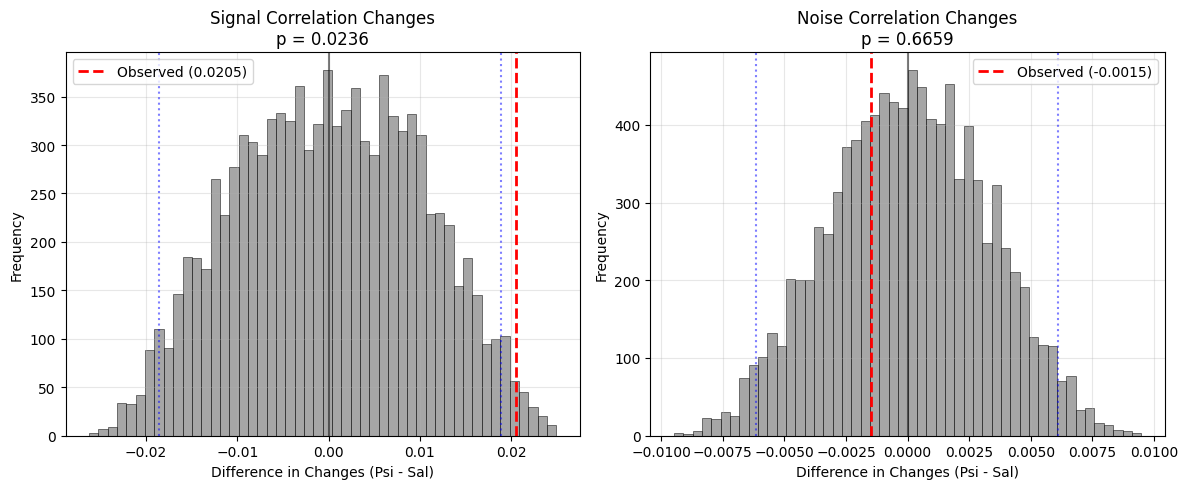

In [42]:
def permutation_test_correlation_changes(saline_pre, saline_post, psi_pre, psi_post, 
                                       n_permutations=10000, random_state=42):
    """
    Permutation tests for signal and noise correlation changes
    """
    import numpy as np
    from scipy import stats
    
    np.random.seed(random_state)
    
    # Helper function to get mouse-level changes
    def get_mouse_changes(pre_df, post_df, corr_type):
        changes = []
        mice = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                m_pre = pre_df[pre_df['mouse_id'] == mouse][f'{corr_type}_correlation'].mean()
                m_post = post_df[post_df['mouse_id'] == mouse][f'{corr_type}_correlation'].mean()
                changes.append(m_post - m_pre)
                mice.append(mouse)
        return np.array(changes), mice
    
    # Permutation test function
    def permutation_test(group1, group2, n_perm=n_permutations):
        observed_diff = np.mean(group2) - np.mean(group1)
        combined = np.concatenate([group1, group2])
        n1 = len(group1)
        
        perm_diffs = []
        for _ in range(n_perm):
            np.random.shuffle(combined)
            perm_diff = np.mean(combined[n1:]) - np.mean(combined[:n1])
            perm_diffs.append(perm_diff)
        
        perm_diffs = np.array(perm_diffs)
        p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_perm
        
        return observed_diff, p_value, perm_diffs
    
    print("="*60)
    print("PERMUTATION TESTS FOR CORRELATION CHANGES")
    print("="*60)
    
    results = {}
    
    # Test both signal and noise correlations
    for corr_type in ['signal', 'noise']:
        print(f"\n{corr_type.upper()} CORRELATIONS")
        print("-"*40)
        
        # Get mouse-level changes
        sal_changes, sal_mice = get_mouse_changes(saline_pre, saline_post, corr_type)
        psi_changes, psi_mice = get_mouse_changes(psi_pre, psi_post, corr_type)
        
        print(f"Saline: n={len(sal_changes)} mice, mean change = {sal_changes.mean():.4f} ± {sal_changes.std():.4f}")
        print(f"Psilocybin: n={len(psi_changes)} mice, mean change = {psi_changes.mean():.4f} ± {psi_changes.std():.4f}")
        
        # Permutation test
        diff, p_val, perm_diffs = permutation_test(sal_changes, psi_changes)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((sal_changes.std()**2 + psi_changes.std()**2) / 2)
        cohen_d = diff / pooled_std if pooled_std > 0 else 0
        
        # Calculate confidence interval from permutation distribution
        ci_lower = np.percentile(perm_diffs, 2.5)
        ci_upper = np.percentile(perm_diffs, 97.5)
        
        print(f"\nDifference (Psi - Sal): {diff:.4f}")
        print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        print(f"Cohen's d: {cohen_d:.3f}")
        print(f"Permutation p-value: {p_val:.4f} {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''}")
        
        # Also run traditional Mann-Whitney for comparison
        u_stat, mw_p = stats.mannwhitneyu(sal_changes, psi_changes, alternative='two-sided')
        print(f"Mann-Whitney p-value: {mw_p:.4f}")
        
        results[corr_type] = {
            'difference': diff,
            'p_permutation': p_val,
            'p_mannwhitney': mw_p,
            'cohen_d': cohen_d,
            'ci': (ci_lower, ci_upper),
            'perm_distribution': perm_diffs
        }
    
    # Visualization
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for idx, corr_type in enumerate(['signal', 'noise']):
        ax = axes[idx]
        
        # Plot permutation distribution
        perm_diffs = results[corr_type]['perm_distribution']
        observed = results[corr_type]['difference']
        
        ax.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black', linewidth=0.5)
        ax.axvline(observed, color='red', linestyle='--', linewidth=2, label=f'Observed ({observed:.4f})')
        ax.axvline(0, color='black', linestyle='-', alpha=0.5)
        
        # Add significance threshold lines
        ax.axvline(np.percentile(perm_diffs, 2.5), color='blue', linestyle=':', alpha=0.5)
        ax.axvline(np.percentile(perm_diffs, 97.5), color='blue', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Difference in Changes (Psi - Sal)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{corr_type.title()} Correlation Changes\np = {results[corr_type]["p_permutation"]:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the analysis
results = permutation_test_correlation_changes(
    signoise_saline_pre, signoise_saline_post, 
    signoise_psilo_pre, signoise_psilo_post
)

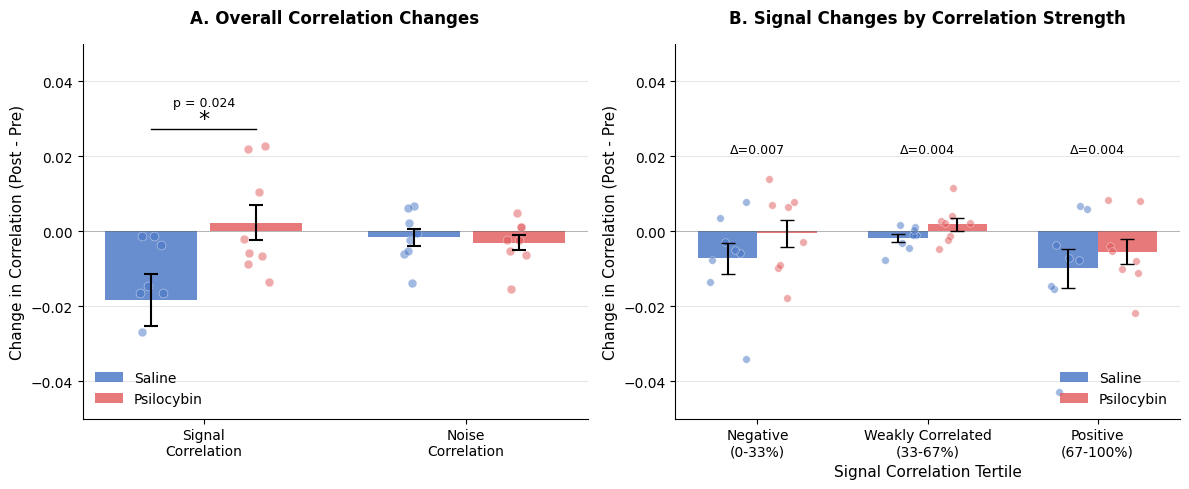

Summary Statistics:
--------------------------------------------------
Signal Correlation - Overall Effect:
  Saline: -0.0183 ± 0.0197
  Psilocybin: 0.0022 ± 0.0133
  Difference: 0.0205

Signal Correlation - Tertile Differences (Psi - Sal):
  Low: 0.0068
  Medium: 0.0036
  High: 0.0044


In [58]:
def create_correlation_results_figure(saline_pre, saline_post, psi_pre, psi_post):
    """
    Create figure showing main effects and tertile consistency
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Helper function to get mouse-level changes
    def get_mouse_changes(pre_df, post_df, corr_type):
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                m_pre = pre_df[pre_df['mouse_id'] == mouse][f'{corr_type}_correlation'].mean()
                m_post = post_df[post_df['mouse_id'] == mouse][f'{corr_type}_correlation'].mean()
                changes.append(m_post - m_pre)
        return np.array(changes)
    
    # Get tertile changes for signal
    def get_tertile_changes(pre_df, post_df, corr_type='signal'):
        all_pre = pd.concat([pre_df, post_df])
        thresholds = np.percentile(all_pre[f'{corr_type}_correlation'], [0, 33.33, 66.67, 100])
        
        tertile_data = {'saline': [], 'psi': []}
        
        for tertile_idx in range(3):
            lower = thresholds[tertile_idx]
            upper = thresholds[tertile_idx + 1]
            
            # Saline changes
            sal_changes = []
            for mouse in saline_pre['mouse_id'].unique():
                if mouse in saline_post['mouse_id'].unique():
                    m_pre = saline_pre[saline_pre['mouse_id'] == mouse]
                    m_post = saline_post[saline_post['mouse_id'] == mouse]
                    
                    if tertile_idx == 2:
                        pre_vals = m_pre[(m_pre[f'{corr_type}_correlation'] >= lower) & 
                                       (m_pre[f'{corr_type}_correlation'] <= upper)][f'{corr_type}_correlation']
                        post_vals = m_post[(m_post[f'{corr_type}_correlation'] >= lower) & 
                                         (m_post[f'{corr_type}_correlation'] <= upper)][f'{corr_type}_correlation']
                    else:
                        pre_vals = m_pre[(m_pre[f'{corr_type}_correlation'] >= lower) & 
                                       (m_pre[f'{corr_type}_correlation'] < upper)][f'{corr_type}_correlation']
                        post_vals = m_post[(m_post[f'{corr_type}_correlation'] >= lower) & 
                                         (m_post[f'{corr_type}_correlation'] < upper)][f'{corr_type}_correlation']
                    
                    if len(pre_vals) >= 5 and len(post_vals) >= 5:
                        sal_changes.append(post_vals.mean() - pre_vals.mean())
            
            # Psi changes
            psi_changes = []
            for mouse in psi_pre['mouse_id'].unique():
                if mouse in psi_post['mouse_id'].unique():
                    m_pre = psi_pre[psi_pre['mouse_id'] == mouse]
                    m_post = psi_post[psi_post['mouse_id'] == mouse]
                    
                    if tertile_idx == 2:
                        pre_vals = m_pre[(m_pre[f'{corr_type}_correlation'] >= lower) & 
                                       (m_pre[f'{corr_type}_correlation'] <= upper)][f'{corr_type}_correlation']
                        post_vals = m_post[(m_post[f'{corr_type}_correlation'] >= lower) & 
                                         (m_post[f'{corr_type}_correlation'] <= upper)][f'{corr_type}_correlation']
                    else:
                        pre_vals = m_pre[(m_pre[f'{corr_type}_correlation'] >= lower) & 
                                       (m_pre[f'{corr_type}_correlation'] < upper)][f'{corr_type}_correlation']
                        post_vals = m_post[(m_post[f'{corr_type}_correlation'] >= lower) & 
                                         (m_post[f'{corr_type}_correlation'] < upper)][f'{corr_type}_correlation']
                    
                    if len(pre_vals) >= 5 and len(post_vals) >= 5:
                        psi_changes.append(post_vals.mean() - pre_vals.mean())
            
            tertile_data['saline'].append(sal_changes)
            tertile_data['psi'].append(psi_changes)
        
        return tertile_data
    
    # Create figure
    fig = plt.figure(figsize=(12, 5))
    
    # Define colors
    sal_color = '#4472C4'  # Professional blue
    psi_color = '#E15759'  # Professional red
    
    # PANEL A: Main effects
    ax1 = plt.subplot(121)
    
    # Get changes for both correlation types
    sal_signal = get_mouse_changes(saline_pre, saline_post, 'signal')
    psi_signal = get_mouse_changes(psi_pre, psi_post, 'signal')
    sal_noise = get_mouse_changes(saline_pre, saline_post, 'noise')
    psi_noise = get_mouse_changes(psi_pre, psi_post, 'noise')
    
    # Positions
    x_signal = [0.8, 1.2]
    x_noise = [1.8, 2.2]
    
    # Plot bars
    bars1 = ax1.bar(x_signal, [sal_signal.mean(), psi_signal.mean()], 
                    width=0.35, color=[sal_color, psi_color], alpha=0.8, 
                    label=['Saline', 'Psilocybin'])
    
    bars2 = ax1.bar(x_noise, [sal_noise.mean(), psi_noise.mean()], 
                    width=0.35, color=[sal_color, psi_color], alpha=0.8)
    
    # Add error bars
    ax1.errorbar(x_signal, [sal_signal.mean(), psi_signal.mean()], 
                 yerr=[sal_signal.std()/np.sqrt(len(sal_signal)), 
                       psi_signal.std()/np.sqrt(len(psi_signal))],
                 fmt='none', color='black', capsize=5, capthick=1.5)
    
    ax1.errorbar(x_noise, [sal_noise.mean(), psi_noise.mean()], 
                 yerr=[sal_noise.std()/np.sqrt(len(sal_noise)), 
                       psi_noise.std()/np.sqrt(len(psi_noise))],
                 fmt='none', color='black', capsize=5, capthick=1.5)
    
    # Add individual points
    np.random.seed(42)
    jitter = 0.05
    for i, val in enumerate(sal_signal):
        ax1.scatter(x_signal[0] + np.random.uniform(-jitter, jitter), val, 
                   color=sal_color, alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
    for i, val in enumerate(psi_signal):
        ax1.scatter(x_signal[1] + np.random.uniform(-jitter, jitter), val, 
                   color=psi_color, alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
    
    for i, val in enumerate(sal_noise):
        ax1.scatter(x_noise[0] + np.random.uniform(-jitter, jitter), val, 
                   color=sal_color, alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
    for i, val in enumerate(psi_noise):
        ax1.scatter(x_noise[1] + np.random.uniform(-jitter, jitter), val, 
                   color=psi_color, alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
    
    # Add significance annotation
    y_max = max(np.concatenate([sal_signal, psi_signal, sal_noise, psi_noise])) * 1.2
    ax1.plot([x_signal[0], x_signal[1]], [y_max, y_max], 'k-', linewidth=1)
    ax1.text(np.mean(x_signal), y_max * 1, '*', fontsize=16, ha='center', va='bottom')
    ax1.text(np.mean(x_signal), y_max * 1.2, 'p = 0.024', fontsize=9, ha='center', va='bottom')
    
    # Formatting
    ax1.set_xticks([1, 2])
    ax1.set_xticklabels(['Signal\nCorrelation', 'Noise\nCorrelation'])
    ax1.set_ylabel('Change in Correlation (Post - Pre)', fontsize=11)
    ax1.set_title('A. Overall Correlation Changes', fontsize=12, fontweight='bold', pad=15)
    ax1.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    ax1.set_ylim(-0.05, 0.05)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=sal_color, alpha=0.8, label='Saline'),
                      plt.Rectangle((0,0),1,1, facecolor=psi_color, alpha=0.8, label='Psilocybin')]
    ax1.legend(handles=legend_elements, loc='lower left', frameon=False)
    
    # PANEL B: Tertile analysis for signal
    ax2 = plt.subplot(122)
    
    tertile_data = get_tertile_changes(saline_pre, saline_post, 'signal')
    
    # Calculate means and SEMs for each tertile
    tertile_means_sal = [np.mean(t) for t in tertile_data['saline']]
    tertile_means_psi = [np.mean(t) for t in tertile_data['psi']]
    tertile_sems_sal = [np.std(t)/np.sqrt(len(t)) if len(t) > 0 else 0 for t in tertile_data['saline']]
    tertile_sems_psi = [np.std(t)/np.sqrt(len(t)) if len(t) > 0 else 0 for t in tertile_data['psi']]
    
    # Bar positions
    x = np.arange(3)
    width = 0.35
    
    # Plot bars
    bars1 = ax2.bar(x - width/2, tertile_means_sal, width, 
                    yerr=tertile_sems_sal, capsize=5,
                    color=sal_color, alpha=0.8, label='Saline')
    bars2 = ax2.bar(x + width/2, tertile_means_psi, width, 
                    yerr=tertile_sems_psi, capsize=5,
                    color=psi_color, alpha=0.8, label='Psilocybin')
    
    # Add individual points
    for i in range(3):
        sal_vals = tertile_data['saline'][i]
        psi_vals = tertile_data['psi'][i]
        
        for val in sal_vals:
            ax2.scatter(i - width/2 + np.random.uniform(-width/3, width/3), val,
                       color=sal_color, alpha=0.5, s=30, edgecolor='white', linewidth=0.5)
        for val in psi_vals:
            ax2.scatter(i + width/2 + np.random.uniform(-width/3, width/3), val,
                       color=psi_color, alpha=0.5, s=30, edgecolor='white', linewidth=0.5)
    
    # Add difference annotations
    for i in range(3):
        diff = tertile_means_psi[i] - tertile_means_sal[i]
        ax2.text(i, 0.02, f'Δ={diff:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Formatting
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Negative\n(0-33%)', 'Weakly Correlated\n(33-67%)', 'Positive\n(67-100%)'])
    ax2.set_xlabel('Signal Correlation Tertile', fontsize=11)
    ax2.set_ylabel('Change in Correlation (Post - Pre)', fontsize=11)
    ax2.set_title('B. Signal Changes by Correlation Strength', fontsize=12, fontweight='bold', pad=15)
    ax2.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    ax2.set_ylim(-0.05, 0.05)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(loc='lower right', frameon=False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Summary Statistics:")
    print("-" * 50)
    print(f"Signal Correlation - Overall Effect:")
    print(f"  Saline: {sal_signal.mean():.4f} ± {sal_signal.std():.4f}")
    print(f"  Psilocybin: {psi_signal.mean():.4f} ± {psi_signal.std():.4f}")
    print(f"  Difference: {psi_signal.mean() - sal_signal.mean():.4f}")
    print(f"\nSignal Correlation - Tertile Differences (Psi - Sal):")
    for i, label in enumerate(['Low', 'Medium', 'High']):
        diff = tertile_means_psi[i] - tertile_means_sal[i]
        print(f"  {label}: {diff:.4f}")

# Create the figure
create_correlation_results_figure(signoise_saline_pre, signoise_saline_post, 
                                 signoise_psilo_pre, signoise_psilo_post)

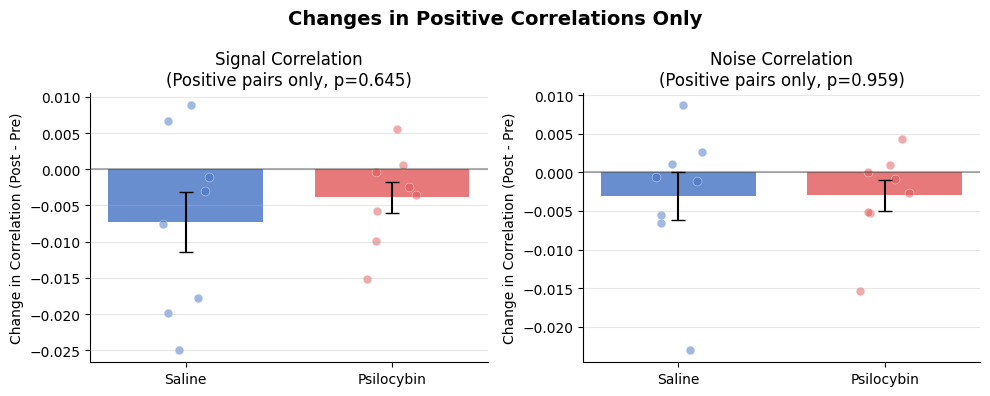

POSITIVE CORRELATIONS ONLY (r > 0)

SIGNAL:
  Saline: -0.0073 ± 0.0117 (n=8)
  Psilocybin: -0.0039 ± 0.0060 (n=8)
  Difference: 0.0034, p=0.6454

NOISE:
  Saline: -0.0031 ± 0.0088 (n=8)
  Psilocybin: -0.0030 ± 0.0055 (n=8)
  Difference: 0.0001, p=0.9591


In [59]:
def analyze_positive_correlations(saline_pre, saline_post, psi_pre, psi_post, threshold=0):
    """Analyze changes in positive correlations only"""
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Get mouse-level changes for positive correlations
    def get_positive_changes(pre_df, post_df, corr_type):
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                # Filter positive correlations
                pre_pos = pre_df[(pre_df['mouse_id']==mouse) & 
                                (pre_df[f'{corr_type}_correlation']>threshold)][f'{corr_type}_correlation']
                post_pos = post_df[(post_df['mouse_id']==mouse) & 
                                  (post_df[f'{corr_type}_correlation']>threshold)][f'{corr_type}_correlation']
                if len(pre_pos)>0 and len(post_pos)>0:
                    changes.append(post_pos.mean() - pre_pos.mean())
        return np.array(changes)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    colors = {'sal': '#4472C4', 'psi': '#E15759'}
    
    for idx, corr_type in enumerate(['signal', 'noise']):
        ax = [ax1, ax2][idx]
        
        # Get changes
        sal_changes = get_positive_changes(saline_pre, saline_post, corr_type)
        psi_changes = get_positive_changes(psi_pre, psi_post, corr_type)
        
        # Plot bars with points
        x = [0.8, 1.2]
        means = [sal_changes.mean(), psi_changes.mean()]
        sems = [sal_changes.std()/np.sqrt(len(sal_changes)), 
                psi_changes.std()/np.sqrt(len(psi_changes))]
        
        ax.bar(x, means, width=0.3, color=[colors['sal'], colors['psi']], 
               alpha=0.8, yerr=sems, capsize=5)
        
        # Add individual points
        np.random.seed(42)
        for i, (vals, pos) in enumerate([(sal_changes, x[0]), (psi_changes, x[1])]):
            jitter = np.random.uniform(-0.05, 0.05, len(vals))
            ax.scatter(pos + jitter, vals, color=list(colors.values())[i], 
                      alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
        
        # Stats
        _, p_val = stats.mannwhitneyu(sal_changes, psi_changes, alternative='two-sided')
        
        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels(['Saline', 'Psilocybin'])
        ax.set_ylabel('Change in Correlation (Post - Pre)')
        ax.set_title(f'{corr_type.title()} Correlation\n(Positive pairs only, p={p_val:.3f})')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax.grid(True, alpha=0.3, axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add significance markers
        if p_val < 0.05:
            y_max = ax.get_ylim()[1] * 0.9
            ax.plot(x, [y_max]*2, 'k-', linewidth=1)
            ax.text(1, y_max, '*' if p_val<0.05 else '**' if p_val<0.01 else '***', 
                   ha='center', va='bottom', fontsize=14)
    
    plt.suptitle('Changes in Positive Correlations Only', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("POSITIVE CORRELATIONS ONLY (r > 0)")
    print("="*50)
    for corr_type in ['signal', 'noise']:
        sal = get_positive_changes(saline_pre, saline_post, corr_type)
        psi = get_positive_changes(psi_pre, psi_post, corr_type)
        _, p = stats.mannwhitneyu(sal, psi, alternative='two-sided')
        print(f"\n{corr_type.upper()}:")
        print(f"  Saline: {sal.mean():.4f} ± {sal.std():.4f} (n={len(sal)})")
        print(f"  Psilocybin: {psi.mean():.4f} ± {psi.std():.4f} (n={len(psi)})")
        print(f"  Difference: {psi.mean()-sal.mean():.4f}, p={p:.4f}")

# Run analysis
analyze_positive_correlations(signoise_saline_pre, signoise_saline_post, 
                            signoise_psilo_pre, signoise_psilo_post)

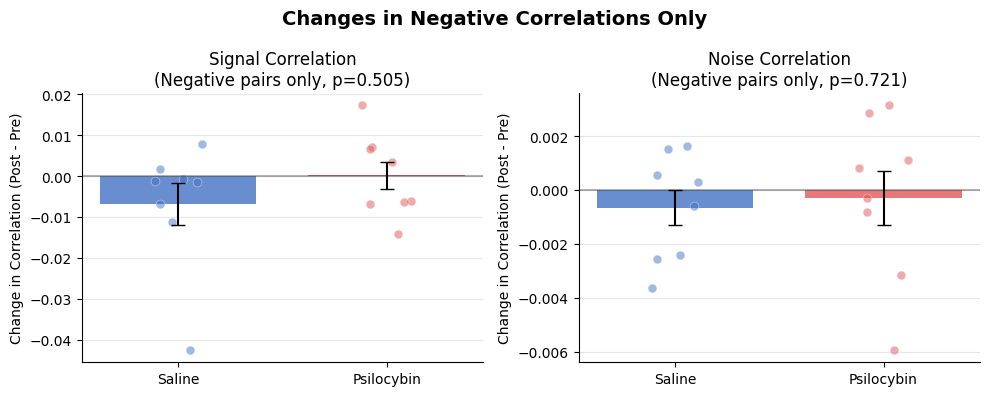

NEGATIVE CORRELATIONS ONLY (r < 0)

SIGNAL:
  Saline: -0.0068 ± 0.0145 (n=8)
  Psilocybin: 0.0001 ± 0.0095 (n=8)
  Difference: 0.0069, p=0.5054

NOISE:
  Saline: -0.0007 ± 0.0019 (n=8)
  Psilocybin: -0.0003 ± 0.0029 (n=8)
  Difference: 0.0004, p=0.7209


In [61]:
def analyze_negative_correlations(saline_pre, saline_post, psi_pre, psi_post, threshold=0):
    """Analyze changes in negative correlations only"""
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Get mouse-level changes for negative correlations
    def get_negative_changes(pre_df, post_df, corr_type):
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                # Filter negative correlations
                pre_neg = pre_df[(pre_df['mouse_id']==mouse) & 
                                (pre_df[f'{corr_type}_correlation']<threshold)][f'{corr_type}_correlation']
                post_neg = post_df[(post_df['mouse_id']==mouse) & 
                                  (post_df[f'{corr_type}_correlation']<threshold)][f'{corr_type}_correlation']
                if len(pre_neg)>0 and len(post_neg)>0:
                    changes.append(post_neg.mean() - pre_neg.mean())
        return np.array(changes)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    colors = {'sal': '#4472C4', 'psi': '#E15759'}
    
    for idx, corr_type in enumerate(['signal', 'noise']):
        ax = [ax1, ax2][idx]
        
        # Get changes
        sal_changes = get_negative_changes(saline_pre, saline_post, corr_type)
        psi_changes = get_negative_changes(psi_pre, psi_post, corr_type)
        
        # Plot bars with points
        x = [0.8, 1.2]
        means = [sal_changes.mean(), psi_changes.mean()]
        sems = [sal_changes.std()/np.sqrt(len(sal_changes)), 
                psi_changes.std()/np.sqrt(len(psi_changes))]
        
        ax.bar(x, means, width=0.3, color=[colors['sal'], colors['psi']], 
               alpha=0.8, yerr=sems, capsize=5)
        
        # Add individual points
        np.random.seed(42)
        for i, (vals, pos) in enumerate([(sal_changes, x[0]), (psi_changes, x[1])]):
            jitter = np.random.uniform(-0.05, 0.05, len(vals))
            ax.scatter(pos + jitter, vals, color=list(colors.values())[i], 
                      alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
        
        # Stats
        _, p_val = stats.mannwhitneyu(sal_changes, psi_changes, alternative='two-sided')
        
        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels(['Saline', 'Psilocybin'])
        ax.set_ylabel('Change in Correlation (Post - Pre)')
        ax.set_title(f'{corr_type.title()} Correlation\n(Negative pairs only, p={p_val:.3f})')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax.grid(True, alpha=0.3, axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add significance markers
        if p_val < 0.05:
            y_max = ax.get_ylim()[1] * 0.9
            ax.plot(x, [y_max]*2, 'k-', linewidth=1)
            ax.text(1, y_max, '*' if p_val<0.05 else '**' if p_val<0.01 else '***', 
                   ha='center', va='bottom', fontsize=14)
    
    plt.suptitle('Changes in Negative Correlations Only', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("NEGATIVE CORRELATIONS ONLY (r < 0)")
    print("="*50)
    for corr_type in ['signal', 'noise']:
        sal = get_negative_changes(saline_pre, saline_post, corr_type)
        psi = get_negative_changes(psi_pre, psi_post, corr_type)
        _, p = stats.mannwhitneyu(sal, psi, alternative='two-sided')
        print(f"\n{corr_type.upper()}:")
        print(f"  Saline: {sal.mean():.4f} ± {sal.std():.4f} (n={len(sal)})")
        print(f"  Psilocybin: {psi.mean():.4f} ± {psi.std():.4f} (n={len(psi)})")
        print(f"  Difference: {psi.mean()-sal.mean():.4f}, p={p:.4f}")

# Run analysis
analyze_negative_correlations(signoise_saline_pre, signoise_saline_post, 
                            signoise_psilo_pre, signoise_psilo_post)

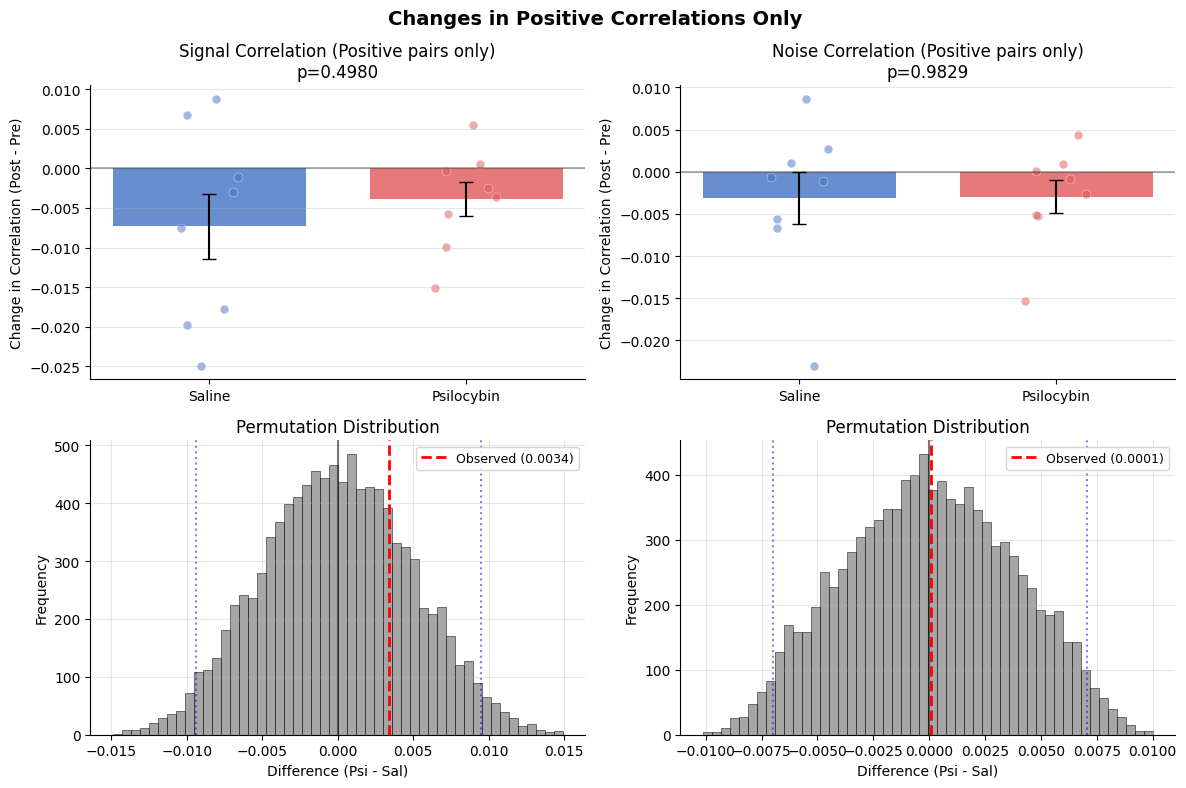

POSITIVE CORRELATIONS ONLY (r > 0)

SIGNAL:
  Saline: -0.0073 ± 0.0117 (n=8)
  Psilocybin: -0.0039 ± 0.0060 (n=8)
  Difference: 0.0034, p=0.4980

NOISE:
  Saline: -0.0031 ± 0.0088 (n=8)
  Psilocybin: -0.0030 ± 0.0055 (n=8)
  Difference: 0.0001, p=0.9829


In [62]:
def analyze_positive_correlations_permutation(saline_pre, saline_post, psi_pre, psi_post, 
                                            threshold=0, n_permutations=10000):
    """Analyze changes in positive correlations with permutation tests"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get mouse-level changes for positive correlations
    def get_positive_changes(pre_df, post_df, corr_type):
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                pre_pos = pre_df[(pre_df['mouse_id']==mouse) & 
                                (pre_df[f'{corr_type}_correlation']>threshold)][f'{corr_type}_correlation']
                post_pos = post_df[(post_df['mouse_id']==mouse) & 
                                  (post_df[f'{corr_type}_correlation']>threshold)][f'{corr_type}_correlation']
                if len(pre_pos)>0 and len(post_pos)>0:
                    changes.append(post_pos.mean() - pre_pos.mean())
        return np.array(changes)
    
    # Permutation test
    def permutation_test(group1, group2, n_perm=n_permutations):
        observed_diff = np.mean(group2) - np.mean(group1)
        combined = np.concatenate([group1, group2])
        n1 = len(group1)
        
        perm_diffs = []
        np.random.seed(42)
        for _ in range(n_perm):
            np.random.shuffle(combined)
            perm_diff = np.mean(combined[n1:]) - np.mean(combined[:n1])
            perm_diffs.append(perm_diff)
        
        perm_diffs = np.array(perm_diffs)
        p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_perm
        return observed_diff, p_value, perm_diffs
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    colors = {'sal': '#4472C4', 'psi': '#E15759'}
    
    for idx, corr_type in enumerate(['signal', 'noise']):
        # Get changes
        sal_changes = get_positive_changes(saline_pre, saline_post, corr_type)
        psi_changes = get_positive_changes(psi_pre, psi_post, corr_type)
        
        # Permutation test
        obs_diff, p_val, perm_diffs = permutation_test(sal_changes, psi_changes)
        
        # Main panel - bar plot
        ax1 = plt.subplot(2, 2, idx+1)
        
        x = [0.8, 1.2]
        means = [sal_changes.mean(), psi_changes.mean()]
        sems = [sal_changes.std()/np.sqrt(len(sal_changes)), 
                psi_changes.std()/np.sqrt(len(psi_changes))]
        
        ax1.bar(x, means, width=0.3, color=[colors['sal'], colors['psi']], 
               alpha=0.8, yerr=sems, capsize=5)
        
        # Add individual points
        np.random.seed(42)
        for i, (vals, pos) in enumerate([(sal_changes, x[0]), (psi_changes, x[1])]):
            jitter = np.random.uniform(-0.05, 0.05, len(vals))
            ax1.scatter(pos + jitter, vals, color=list(colors.values())[i], 
                      alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
        
        # Formatting
        ax1.set_xticks(x)
        ax1.set_xticklabels(['Saline', 'Psilocybin'])
        ax1.set_ylabel('Change in Correlation (Post - Pre)')
        ax1.set_title(f'{corr_type.title()} Correlation (Positive pairs only)\np={p_val:.4f}')
        ax1.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        
        # Add significance markers
        if p_val < 0.05:
            y_max = ax1.get_ylim()[1] * 0.9
            ax1.plot(x, [y_max]*2, 'k-', linewidth=1)
            ax1.text(1, y_max, '*' if p_val<0.05 else '**' if p_val<0.01 else '***', 
                   ha='center', va='bottom', fontsize=14)
        
        # Permutation distribution panel
        ax2 = plt.subplot(2, 2, idx+3)
        
        ax2.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black', linewidth=0.5)
        ax2.axvline(obs_diff, color='red', linestyle='--', linewidth=2, 
                   label=f'Observed ({obs_diff:.4f})')
        ax2.axvline(0, color='black', linestyle='-', alpha=0.5)
        ax2.axvline(np.percentile(perm_diffs, 2.5), color='blue', linestyle=':', alpha=0.5)
        ax2.axvline(np.percentile(perm_diffs, 97.5), color='blue', linestyle=':', alpha=0.5)
        
        ax2.set_xlabel('Difference (Psi - Sal)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Permutation Distribution')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
    
    plt.suptitle('Changes in Positive Correlations Only', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("POSITIVE CORRELATIONS ONLY (r > 0)")
    print("="*50)
    for corr_type in ['signal', 'noise']:
        sal = get_positive_changes(saline_pre, saline_post, corr_type)
        psi = get_positive_changes(psi_pre, psi_post, corr_type)
        obs_diff, p, _ = permutation_test(sal, psi)
        print(f"\n{corr_type.upper()}:")
        print(f"  Saline: {sal.mean():.4f} ± {sal.std():.4f} (n={len(sal)})")
        print(f"  Psilocybin: {psi.mean():.4f} ± {psi.std():.4f} (n={len(psi)})")
        print(f"  Difference: {obs_diff:.4f}, p={p:.4f}")

# Run analysis
analyze_positive_correlations_permutation(signoise_saline_pre, signoise_saline_post, 
                                        signoise_psilo_pre, signoise_psilo_post)

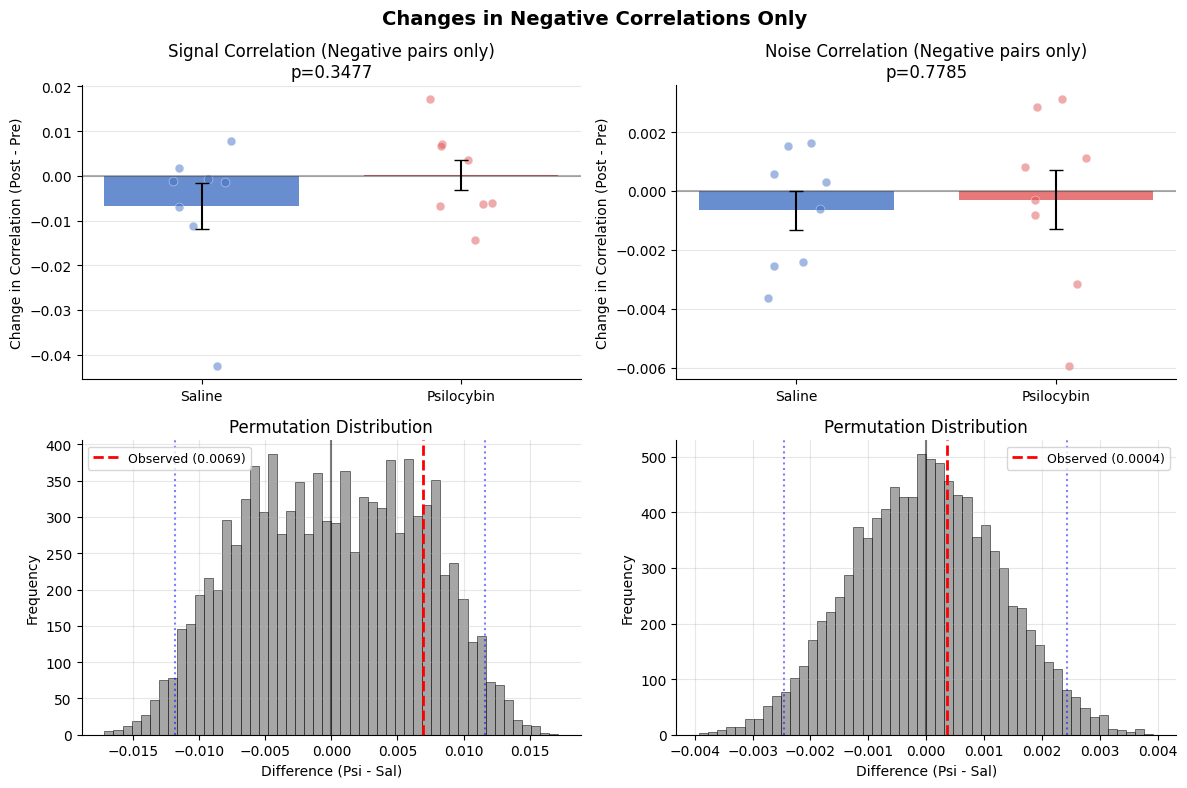

NEGATIVE CORRELATIONS ONLY (r < 0)

SIGNAL:
  Saline: -0.0068 ± 0.0145 (n=8)
  Psilocybin: 0.0001 ± 0.0095 (n=8)
  Difference: 0.0069, p=0.3477

NOISE:
  Saline: -0.0007 ± 0.0019 (n=8)
  Psilocybin: -0.0003 ± 0.0029 (n=8)
  Difference: 0.0004, p=0.7785


In [64]:
def analyze_negative_correlations_permutation(saline_pre, saline_post, psi_pre, psi_post, 
                                            threshold=0, n_permutations=10000):
    """Analyze changes in negative correlations with permutation tests"""
    
    # Get mouse-level changes for negative correlations
    def get_negative_changes(pre_df, post_df, corr_type):
        changes = []
        for mouse in pre_df['mouse_id'].unique():
            if mouse in post_df['mouse_id'].unique():
                pre_neg = pre_df[(pre_df['mouse_id']==mouse) & 
                                (pre_df[f'{corr_type}_correlation']<threshold)][f'{corr_type}_correlation']
                post_neg = post_df[(post_df['mouse_id']==mouse) & 
                                  (post_df[f'{corr_type}_correlation']<threshold)][f'{corr_type}_correlation']
                if len(pre_neg)>0 and len(post_neg)>0:
                    changes.append(post_neg.mean() - pre_neg.mean())
        return np.array(changes)
    
    # Permutation test
    def permutation_test(group1, group2, n_perm=n_permutations):
        observed_diff = np.mean(group2) - np.mean(group1)
        combined = np.concatenate([group1, group2])
        n1 = len(group1)
        
        perm_diffs = []
        np.random.seed(42)
        for _ in range(n_perm):
            np.random.shuffle(combined)
            perm_diff = np.mean(combined[n1:]) - np.mean(combined[:n1])
            perm_diffs.append(perm_diff)
        
        perm_diffs = np.array(perm_diffs)
        p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_perm
        return observed_diff, p_value, perm_diffs
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    colors = {'sal': '#4472C4', 'psi': '#E15759'}
    
    for idx, corr_type in enumerate(['signal', 'noise']):
        # Get changes
        sal_changes = get_negative_changes(saline_pre, saline_post, corr_type)
        psi_changes = get_negative_changes(psi_pre, psi_post, corr_type)
        
        # Permutation test
        obs_diff, p_val, perm_diffs = permutation_test(sal_changes, psi_changes)
        
        # Main panel - bar plot
        ax1 = plt.subplot(2, 2, idx+1)
        
        x = [0.8, 1.2]
        means = [sal_changes.mean(), psi_changes.mean()]
        sems = [sal_changes.std()/np.sqrt(len(sal_changes)), 
                psi_changes.std()/np.sqrt(len(psi_changes))]
        
        ax1.bar(x, means, width=0.3, color=[colors['sal'], colors['psi']], 
               alpha=0.8, yerr=sems, capsize=5)
        
        # Add individual points
        np.random.seed(42)
        for i, (vals, pos) in enumerate([(sal_changes, x[0]), (psi_changes, x[1])]):
            jitter = np.random.uniform(-0.05, 0.05, len(vals))
            ax1.scatter(pos + jitter, vals, color=list(colors.values())[i], 
                      alpha=0.5, s=40, edgecolor='white', linewidth=0.5)
        
        # Formatting
        ax1.set_xticks(x)
        ax1.set_xticklabels(['Saline', 'Psilocybin'])
        ax1.set_ylabel('Change in Correlation (Post - Pre)')
        ax1.set_title(f'{corr_type.title()} Correlation (Negative pairs only)\np={p_val:.4f}')
        ax1.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        
        # Add significance markers
        if p_val < 0.05:
            y_max = ax1.get_ylim()[1] * 0.9
            ax1.plot(x, [y_max]*2, 'k-', linewidth=1)
            ax1.text(1, y_max, '*' if p_val<0.05 else '**' if p_val<0.01 else '***', 
                   ha='center', va='bottom', fontsize=14)
        
        # Permutation distribution panel
        ax2 = plt.subplot(2, 2, idx+3)
        
        ax2.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black', linewidth=0.5)
        ax2.axvline(obs_diff, color='red', linestyle='--', linewidth=2, 
                   label=f'Observed ({obs_diff:.4f})')
        ax2.axvline(0, color='black', linestyle='-', alpha=0.5)
        ax2.axvline(np.percentile(perm_diffs, 2.5), color='blue', linestyle=':', alpha=0.5)
        ax2.axvline(np.percentile(perm_diffs, 97.5), color='blue', linestyle=':', alpha=0.5)
        
        ax2.set_xlabel('Difference (Psi - Sal)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Permutation Distribution')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
    
    plt.suptitle('Changes in Negative Correlations Only', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("NEGATIVE CORRELATIONS ONLY (r < 0)")
    print("="*50)
    for corr_type in ['signal', 'noise']:
        sal = get_negative_changes(saline_pre, saline_post, corr_type)
        psi = get_negative_changes(psi_pre, psi_post, corr_type)
        obs_diff, p, _ = permutation_test(sal, psi)
        print(f"\n{corr_type.upper()}:")
        print(f"  Saline: {sal.mean():.4f} ± {sal.std():.4f} (n={len(sal)})")
        print(f"  Psilocybin: {psi.mean():.4f} ± {psi.std():.4f} (n={len(psi)})")
        print(f"  Difference: {obs_diff:.4f}, p={p:.4f}")

# Run analysis
analyze_negative_correlations_permutation(signoise_saline_pre, signoise_saline_post, 
                                        signoise_psilo_pre, signoise_psilo_post)